In [2]:
import shap
import pickle
from transformers import AutoTokenizer
import numpy as np
import transformers
import shap
from src.plot_text import text
from src.utils import format_fts_for_plotting, text_ft_index_ends, token_segments
from src.utils import legacy_get_dataset_info
from datasets import load_dataset
import matplotlib.pyplot as plt
from src.run_shap import load_shap_vals
from tqdm import tqdm
import re
import seaborn as sns
from scipy import stats
import pandas as pd

/home/james/CodingProjects/TextNTabularExplanations/env/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
def gen_summary_shap_vals(
    ds_name, text_model_code, add_parent_dir=False, tab_scale_factor=2
):
    di = legacy_get_dataset_info(ds_name)
    shap_groups, names = load_shap_vals(
        ds_name,
        text_model_code=text_model_code,
        add_parent_dir=add_parent_dir,
        tab_scale_factor=tab_scale_factor,
    )
    if text_model_code == "disbert":
        text_model_base = "distilbert-base-uncased"
    elif text_model_code == "bert":
        text_model_base = "bert-base-uncased"
    elif text_model_code == "drob":
        text_model_base = "distilroberta-base"
    elif text_model_code == "deberta":
        text_model_base = "microsoft/deberta-v3-small"
    else:
        raise ValueError(f"Invalid text model code of {text_model_code}")

    tokenizer = AutoTokenizer.from_pretrained(
        text_model_base, model_max_length=512)

    pre = f"_sf{tab_scale_factor}" if tab_scale_factor != 2 else ""
    text_model_name = f"_{text_model_code}"

    # for shap_vals, name in zip(shap_groups[:-1], names[:-1]):
    #     print(
    #         f"""
    #         #################
    #         {name}
    #         #################
    #         """
    #     )
    #     filepath = f"models/shap_vals{text_model_name}{pre}/{ds_name}/summed_shap_vals_{name}.pkl"
    #     grouped_shap_vals = []
    #     for label in range(len(di.label_names)):
    #         shap_for_label = []
    #         for idx in tqdm(range(len(shap_vals))):
    #             sv = shap_vals[idx, :, label]
    #             text_ft_ends = text_ft_index_ends(
    #                 sv.data[len(di.tab_cols) :], tokenizer
    #             )
    #             text_ft_ends = [len(di.tab_cols)] + [
    #                 x + len(di.tab_cols) + 1 for x in text_ft_ends
    #             ]
    #             val = np.append(
    #                 sv.values[: len(di.tab_cols)],
    #                 [
    #                     np.sum(sv.values[text_ft_ends[i] : text_ft_ends[i + 1]])
    #                     for i in range(len(text_ft_ends) - 1)
    #                 ]
    #                 + [np.sum(sv.values[text_ft_ends[-1] :])],
    #             )

    #             shap_for_label.append(val)
    #         grouped_shap_vals.append(np.vstack(shap_for_label))
    #     print(f"Saving to {filepath}")
    #     with open(filepath, "wb") as f:
    #         pickle.dump(np.array(grouped_shap_vals), f)

    print(
        f"""
        #################
        All as Text Baseline
        #################
        """
    )
    shap_vals = shap_groups[-1]
    mem_filepath = f"../models/shap_vals{text_model_name}{pre}/{ds_name}/shap_vals_all_text_baseline_memberships.pkl"
    grouped_memberships = []
    # for label in range(len(di.label_names)):
    #     memberships = []
    label = 0
    for idx in tqdm(range(len(shap_vals))):
        sv = shap_vals[idx, :, label]
        stripped_data = np.array([item.strip() for item in sv.data])
        text_ft_ends = [1] + \
            list(np.where(stripped_data == "|")[0]) + [len(sv.data)]
        # Need this if there are | in the text that aren't col separators
        # Not super robust and only implemented for the current col to text mapping, but works for now
        if len(text_ft_ends) != len(di.text_cols + di.tab_cols) + 1:
            text_ft_ends = (
                [1]
                + [
                    i
                    for i in list(np.where(stripped_data == "|")[0])
                    if sv.data[i + 1].strip()
                    in [
                        token_segments(col, tokenizer)[0][1].strip()
                        for col in di.tab_cols + di.text_cols
                    ]
                    + di.tab_cols
                    + di.text_cols
                ]
                + [len(sv.data)]
            )
        assert len(text_ft_ends) == len(di.text_cols + di.tab_cols) + 1
        # val = np.array(
        #     [
        #         np.sum(sv.values[text_ft_ends[i]: text_ft_ends[i + 1]])
        #         for i in range(len(text_ft_ends) - 1)
        #     ]
        # )
        colon_idxs = np.where(stripped_data == ":")[0]
        col_idxs_after_ft = [
            colon_idxs[list(np.where(colon_idxs > te)[0])[0]]
            for te in text_ft_ends[:-1]
        ]
        # ft_name_vals = np.array(
        #     [
        #         np.sum(sv.values[text_ft_ends[i]: col_idxs_after_ft[i]])
        #         for i in range(len(text_ft_ends) - 1)
        #     ]
        # )

        membership = ["" for _ in range(len(sv.values))]
        for i in range(len(text_ft_ends) - 1):
            if i < len(di.tab_cols):
                membership[text_ft_ends[i]: text_ft_ends[i + 1]] = [f"cat_{i}_tab"] * (
                    text_ft_ends[i + 1] - text_ft_ends[i]
                )
            else:
                membership[text_ft_ends[i]: text_ft_ends[i + 1]] = [
                    f"cat_{i}_text"
                ] * (text_ft_ends[i + 1] - text_ft_ends[i])
        # overwrite if colon or feat name
        for i in range(len(text_ft_ends) - 1):
            membership[text_ft_ends[i]: col_idxs_after_ft[i] + 1] = [
                f"template_{i}"
            ] * (col_idxs_after_ft[i] - text_ft_ends[i] + 1)
        membership[0] = "first"
        membership[-1] = "last"

        # colon_vals = np.array(sv.values[col_idxs_after_ft])
        # shap_for_label.append(val)
        # shap_for_col_name.append(ft_name_vals)
        # shap_for_colon.append(colon_vals)
        #     grouped_shap_vals.append(np.vstack(shap_for_label))
        #     grouped_col_name_shap_vals.append(shap_for_col_name)
        #     grouped_colon_shap_vals.append(shap_for_colon)
        grouped_memberships.append(membership)
    print(f"Saving to {mem_filepath}")
    with open(mem_filepath, "wb") as f:
        pickle.dump(np.array(grouped_memberships), f)
    # print(f"Saving to {col_name_filepath}")
    # with open(col_name_filepath, "wb") as f:
    #     pickle.dump(np.array(grouped_col_name_shap_vals), f)
    # print(f"Saving to {colon_filepath}")
    # with open(colon_filepath, "wb") as f:
    #     pickle.dump(np.array(grouped_colon_shap_vals), f)

In [3]:
sf = 1
for text_model_code in [
    "disbert",
    "bert",
    "drob",
    "deberta",
]:
    for ds_name in [
        "prod_sent",
        "kick",
        "jigsaw",
        "wine",
        "fake",
        "imdb_genre",
        "channel",
        "airbnb",
        "salary",
    ]:
        # for model_type in [
        #     "ensemble_50",
        #     "ensemble_75",
        #     "ensemble_25",
        #     "stack",
        #     "all_text",
        # ]:

        # gen_summary_shap_vals(
        #     ds_name,
        #     text_model_code=text_model_code,
        #     tab_scale_factor=sf,
        #     add_parent_dir=True,
        # )


No model type specified for prod_sent. (This is fine during dataset creation)



        #################
        All as Text Baseline
        #################
        


100%|██████████| 100/100 [00:00<00:00, 224.62it/s]
Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
No model type specified for kick. (This is fine during dataset creation)


Saving to ../models/shap_vals_disbert_sf1/prod_sent/shap_vals_all_text_baseline_memberships.pkl

        #################
        All as Text Baseline
        #################
        


100%|██████████| 100/100 [00:00<00:00, 100.18it/s]
No model type specified for jigsaw. (This is fine during dataset creation)


Saving to ../models/shap_vals_disbert_sf1/kick/shap_vals_all_text_baseline_memberships.pkl

        #################
        All as Text Baseline
        #################
        


100%|██████████| 100/100 [00:01<00:00, 60.94it/s]
No model type specified for wine. (This is fine during dataset creation)


Saving to ../models/shap_vals_disbert_sf1/jigsaw/shap_vals_all_text_baseline_memberships.pkl

        #################
        All as Text Baseline
        #################
        


100%|██████████| 100/100 [00:00<00:00, 146.11it/s]
No model type specified for fake. (This is fine during dataset creation)


Saving to ../models/shap_vals_disbert_sf1/wine/shap_vals_all_text_baseline_memberships.pkl

        #################
        All as Text Baseline
        #################
        


100%|██████████| 100/100 [00:01<00:00, 51.79it/s]
No model type specified for imdb_genre. (This is fine during dataset creation)


Saving to ../models/shap_vals_disbert_sf1/fake/shap_vals_all_text_baseline_memberships.pkl

        #################
        All as Text Baseline
        #################
        


100%|██████████| 100/100 [00:00<00:00, 138.91it/s]
No model type specified for channel. (This is fine during dataset creation)


Saving to ../models/shap_vals_disbert_sf1/imdb_genre/shap_vals_all_text_baseline_memberships.pkl

        #################
        All as Text Baseline
        #################
        


100%|██████████| 100/100 [00:01<00:00, 60.05it/s]
No model type specified for airbnb. (This is fine during dataset creation)


Saving to ../models/shap_vals_disbert_sf1/channel/shap_vals_all_text_baseline_memberships.pkl

        #################
        All as Text Baseline
        #################
        


100%|██████████| 100/100 [00:03<00:00, 32.95it/s]
No model type specified for salary. (This is fine during dataset creation)


Saving to ../models/shap_vals_disbert_sf1/airbnb/shap_vals_all_text_baseline_memberships.pkl

        #################
        All as Text Baseline
        #################
        


100%|██████████| 100/100 [00:00<00:00, 147.74it/s]


Saving to ../models/shap_vals_disbert_sf1/salary/shap_vals_all_text_baseline_memberships.pkl

        #################
        All as Text Baseline
        #################
        


100%|██████████| 100/100 [00:00<00:00, 208.03it/s]


Saving to ../models/shap_vals_bert_sf1/prod_sent/shap_vals_all_text_baseline_memberships.pkl

        #################
        All as Text Baseline
        #################
        


100%|██████████| 100/100 [00:01<00:00, 95.62it/s]


Saving to ../models/shap_vals_bert_sf1/kick/shap_vals_all_text_baseline_memberships.pkl

        #################
        All as Text Baseline
        #################
        


100%|██████████| 100/100 [00:01<00:00, 61.50it/s]


Saving to ../models/shap_vals_bert_sf1/jigsaw/shap_vals_all_text_baseline_memberships.pkl

        #################
        All as Text Baseline
        #################
        


100%|██████████| 100/100 [00:00<00:00, 151.46it/s]


Saving to ../models/shap_vals_bert_sf1/wine/shap_vals_all_text_baseline_memberships.pkl

        #################
        All as Text Baseline
        #################
        


100%|██████████| 100/100 [00:01<00:00, 51.33it/s]


Saving to ../models/shap_vals_bert_sf1/fake/shap_vals_all_text_baseline_memberships.pkl

        #################
        All as Text Baseline
        #################
        


100%|██████████| 100/100 [00:00<00:00, 142.51it/s]


Saving to ../models/shap_vals_bert_sf1/imdb_genre/shap_vals_all_text_baseline_memberships.pkl

        #################
        All as Text Baseline
        #################
        


100%|██████████| 100/100 [00:01<00:00, 58.93it/s]


Saving to ../models/shap_vals_bert_sf1/channel/shap_vals_all_text_baseline_memberships.pkl

        #################
        All as Text Baseline
        #################
        


100%|██████████| 100/100 [00:03<00:00, 32.28it/s]


Saving to ../models/shap_vals_bert_sf1/airbnb/shap_vals_all_text_baseline_memberships.pkl

        #################
        All as Text Baseline
        #################
        


100%|██████████| 100/100 [00:00<00:00, 144.41it/s]


Saving to ../models/shap_vals_bert_sf1/salary/shap_vals_all_text_baseline_memberships.pkl

        #################
        All as Text Baseline
        #################
        


100%|██████████| 100/100 [00:00<00:00, 219.70it/s]


Saving to ../models/shap_vals_drob_sf1/prod_sent/shap_vals_all_text_baseline_memberships.pkl

        #################
        All as Text Baseline
        #################
        


100%|██████████| 100/100 [00:00<00:00, 109.76it/s]


Saving to ../models/shap_vals_drob_sf1/kick/shap_vals_all_text_baseline_memberships.pkl

        #################
        All as Text Baseline
        #################
        


 92%|█████████▏| 92/100 [00:01<00:00, 55.43it/s]


KeyboardInterrupt: 

In [43]:
import pandas as pd

sf = 1
memb_results = {}
rows = []
items = []
agg_items = []
for text_model_code in [
    "disbert",
    "bert",
    "drob",
    "deberta",
]:
    for ds_name in [
        "prod_sent",
        "kick",
        "jigsaw",
        "wine",
        "fake",
        "imdb_genre",
        "channel",
        "airbnb",
        "salary",
    ]:
        mem_filepath = f"../models/shap_vals_{text_model_code}_sf{sf}/{ds_name}/shap_vals_all_text_baseline_memberships.pkl"
        with open(mem_filepath, "rb") as f:
            grouped_memberships = pickle.load(f)
        val_filepath = f"../models/shap_vals_{text_model_code}_sf{sf}/{ds_name}/shap_vals_all_text_baseline.pkl"
        with open(val_filepath, "rb") as f:
            shap_vals = pickle.load(f)
        all_divs = []
        for i in range(len(grouped_memberships)):
            # membs, vals = zip(
            #     *sorted(
            #         zip(grouped_memberships[i], np.mean(shap_vals.values[i], axis=1)),
            #         key=lambda x: x[1],
            #         reverse=True,
            #     )
            # )
            membs, vals = grouped_memberships[i], shap_vals.values[i]
            aggregated_values = {}

            for memb, val in zip(membs, vals):
                if memb.startswith("template_"):
                    template_num = re.sub(r"[^0-9]", "", memb)
                    if template_num != "":
                        if template_num in aggregated_values:
                            aggregated_values[memb] += val
                        else:
                            aggregated_values[memb] = val

            # remove templates from membs, vals then add back the aggregated values
            membs, vals = zip(
                *[
                    (memb, val)
                    for memb, val in zip(membs, vals)
                    if not memb.startswith("template_")
                ]
            )
            membs = list(membs)
            vals = list(vals)

            for memb, val in aggregated_values.items():
                membs.append(memb)
                vals.append(val)

            separated_lists = {}
            separated_lists_vals = {}

            for memb, val in zip(membs, vals):
                num = re.sub(r"[^0-9]", "", memb)
                if num != "":
                    if num in separated_lists:
                        separated_lists[num].append(memb)
                        separated_lists_vals[num] = np.vstack(
                            [separated_lists_vals[num], val]
                        )
                    else:
                        separated_lists[num] = [memb]
                        separated_lists_vals[num] = np.array([val])

            row_sum = np.sum(shap_vals.values[i], axis=0)
            total_tokens = len(shap_vals.values[i])
            all_template_vals = np.array(
                [abs(v[-1]) for v in separated_lists_vals.values()]
            )
            all_ft_vals = np.vstack(
                [abs(v[:-1]) for v in separated_lists_vals.values()]
            )
            temp_median = np.median(all_template_vals, axis=0)
            temp_mean = np.mean(all_template_vals, axis=0)
            temp_max = np.max(all_template_vals, axis=0)
            temp_min = np.min(all_template_vals, axis=0)
            ft_median = np.median(all_ft_vals, axis=0)
            ft_mean = np.mean(all_ft_vals, axis=0)
            ft_max = np.max(all_ft_vals, axis=0)
            ft_min = np.min(all_ft_vals, axis=0)

            # Aggregate across labels
            agg_item = {}
            agg_all_template_vals = np.sum(np.abs(all_template_vals), axis=1)
            agg_all_ft_vals = np.sum(np.abs(all_ft_vals), axis=1)
            agg_item["temp_median"] = np.median(agg_all_template_vals)
            agg_item["temp_mean"] = np.mean(agg_all_template_vals)
            agg_item["temp_max"] = np.max(agg_all_template_vals)
            agg_item["temp_min"] = np.min(agg_all_template_vals)
            agg_item["ft_median"] = np.median(agg_all_ft_vals)
            agg_item["ft_mean"] = np.mean(agg_all_ft_vals)
            agg_item["ft_max"] = np.max(agg_all_ft_vals)
            agg_item["ft_min"] = np.min(agg_all_ft_vals)
            agg_item["ds_name"] = ds_name
            agg_item["text_model"] = text_model_code
            # agg_item["num_ft_tokens"] = len(ft_vals)
            agg_item["total_length"] = total_tokens
            agg_items.append(agg_item)

            for label in range(shap_vals.values[i].shape[1]):
                item = {}
                item["temp_median"] = temp_median[label]
                item["temp_mean"] = temp_mean[label]
                item["temp_max"] = temp_max[label]
                item["temp_min"] = temp_min[label]
                item["ft_median"] = ft_median[label]
                item["ft_mean"] = ft_mean[label]
                item["ft_max"] = ft_max[label]
                item["ft_min"] = ft_min[label]
                item["ds_name"] = ds_name
                item["text_model"] = text_model_code
                # item["num_ft_tokens"] = len(ft_vals)
                item["label_sum"] = row_sum[label]
                item["total_length"] = total_tokens
                items.append(item)
                for key, lst in separated_lists.items():
                    if label == 0:
                        agg_row = {}
                        agg_template_val = separated_lists_vals[key][-1, label]

                    row = {}
                    template_val = separated_lists_vals[key][-1, label]
                    ft_vals = separated_lists_vals[key][:-1, label]
                    row["abs_template_vals"] = abs(template_val)
                    row["template_vals"] = template_val
                    row["abs_ft_vals_sum"] = abs(sum(ft_vals))
                    row["ft_vals_sum"] = sum(ft_vals)
                    row["ft_vals_mean"] = np.mean(
                        [abs(val) for val in ft_vals])
                    row["ft_vals_median"] = np.median(
                        [abs(val) for val in ft_vals])
                    row["ft_vals_max"] = max([abs(val) for val in ft_vals])
                    row["ft_vals_min"] = min([abs(val) for val in ft_vals])
                    row["tab_or_text"] = "tab" if "tab" in lst[0] else "text"
                    row["label"] = label
                    row["ft_num"] = key
                    row["example_num"] = i
                    row["ds_name"] = ds_name
                    row["text_model"] = text_model_code
                    row["num_ft_tokens"] = len(ft_vals)
                    row["label_sum"] = row_sum[label]
                    row["total_length"] = total_tokens
                    rows.append(row)
my_df = pd.DataFrame(rows)
my_df.to_csv(f"../models/shap_vals_all_text_baseline_df.csv")
item_df = pd.DataFrame(items)
item_df.to_csv(f"../models/shap_vals_all_text_baseline_instance_level_df.csv")
# find out in what percentile each template is in
#     divs = []
#     for lst in separated_lists.values():
#         template_index = lst.index(
#             next(item for item in lst if item.startswith("template"))
#         )
#         sublist1 = lst[:template_index]
#         sublist2 = lst[template_index + 1 :]
#         try:
#             divs.append(len(sublist2) / (len(sublist1) + len(sublist2)))
#         except:
#             print(lst)
#         divs.append(len(sublist2) / (len(sublist1) + len(sublist2)))
#     all_divs.append(divs)
# memb_results[(text_model_code, ds_name)] = np.mean(all_divs)

## Instance level

In [35]:
import pandas as pd

sf = 1
memb_results = {}
rows = []
items = []
agg_items = []
for text_model_code in [
    "disbert",
    "bert",
    "drob",
    "deberta",
]:
    for ds_name in [
        "prod_sent",
        "kick",
        "jigsaw",
        "wine",
        "fake",
        "imdb_genre",
        "channel",
        "airbnb",
        "salary",
    ]:
        mem_filepath = f"../models/shap_vals_{text_model_code}_sf{sf}/{ds_name}/shap_vals_all_text_baseline_memberships.pkl"
        with open(mem_filepath, "rb") as f:
            grouped_memberships = pickle.load(f)
        val_filepath = f"../models/shap_vals_{text_model_code}_sf{sf}/{ds_name}/shap_vals_all_text_baseline.pkl"
        with open(val_filepath, "rb") as f:
            shap_vals = pickle.load(f)
        all_divs = []
        for i in range(len(grouped_memberships)):
            membs, vals = grouped_memberships[i], shap_vals.values[i]
            aggregated_values = {}
            agg_lens = {}

            for memb, val in zip(membs, vals):
                if memb not in ["first", "last"]:
                    if memb.startswith("template_"):
                        name = "template"
                    else:
                        name = memb
                    if name in aggregated_values:
                        aggregated_values[name] += val
                        agg_lens[name] += 1
                    else:
                        aggregated_values[name] = val
                        agg_lens[name] = 1
            aggregated_values = {
                k: np.sum(np.abs(v)) for k, v in aggregated_values.items()
            }

            total_tokens = len(shap_vals.values[i])
            for name, val in aggregated_values.items():
                row = {}
                row["value"] = val
                row["ds_name"] = ds_name
                row["text_model"] = text_model_code
                row["ft_len"] = agg_lens[name]
                row["rel_ft_len"] = agg_lens[name] / total_tokens
                row["rel_val"] = val / agg_lens[name]
                row["total_length"] = total_tokens
                if name == "template":
                    row["category"] = "template"
                elif "tab" in name:
                    row["category"] = "tab"
                elif "text" in name:
                    row["category"] = "text"
                else:
                    raise ValueError(f"Invalid name of {name}")
                rows.append(row)
agg_df = pd.DataFrame(rows)
agg_df.to_csv(f"../models/shap_vals_all_text_baseline_agg_df.csv")

In [261]:
rel_df

text_model    ds_name category  col_total  col_rel_total  val_total  \
0        disbert  prod_sent      tab   0.092860       0.023215   1.034273   
1        disbert  prod_sent     text   0.057241       0.011448   0.374486   
2        disbert  prod_sent      tab   0.128361       0.032090   1.056072   
3        disbert  prod_sent     text   0.034212       0.006842   0.243508   
4        disbert  prod_sent      tab   0.139443       0.034861   1.071110   
...          ...        ...      ...        ...            ...        ...   
48795    deberta     salary     text   0.104540       0.034847   0.152068   
48796    deberta     salary     text   0.019562       0.003912   0.005835   
48797    deberta     salary     text   0.020372       0.003395   0.100150   
48798    deberta     salary     text   0.025583       0.005117   0.213034   
48799    deberta     salary     text   0.012064       0.004021   0.072615   

       val_rel_total  
0           1.034273  
1           0.014979  
2           1.056072  
3           0.009740  
4           1.071110  
...              ...  
48795       0.038017  
48796       0.005835  
48797       0.016692  
48798       0.013315  
48799       0.014523  

[48800 rows x 7 columns]

## Instance level

In [13]:
import pandas as pd

sf = 1
memb_results = {}
rows = []
items = []
agg_items = []
for text_model_code in [
    "disbert",
    "bert",
    "drob",
    "deberta",
]:
    for ds_name in [
        "prod_sent",
        "kick",
        "jigsaw",
        "wine",
        "fake",
        "imdb_genre",
        "channel",
        "airbnb",
        "salary",
    ]:
        mem_filepath = f"../models/shap_vals_{text_model_code}_sf{sf}/{ds_name}/shap_vals_all_text_baseline_memberships.pkl"
        with open(mem_filepath, "rb") as f:
            grouped_memberships = pickle.load(f)
        val_filepath = f"../models/shap_vals_{text_model_code}_sf{sf}/{ds_name}/shap_vals_all_text_baseline.pkl"
        # val_filepath = f"../models/shap_vals_{text_model_code}_sf{sf}/{ds_name}/summed_shap_vals_all_text.pkl"
        with open(val_filepath, "rb") as f:
            shap_vals = pickle.load(f)
        all_divs = []
        method_dict = {}
        for method in [
            "all_text",
            "ensemble_25",
            "ensemble_50",
            "ensemble_75",
            "stack",
        ]:
            val_filepath = f"../models/shap_vals_{text_model_code}_sf{sf}/{ds_name}/summed_shap_vals_{method}.pkl"
            with open(val_filepath, "rb") as f:
                shap_vals2 = pickle.load(f)
            method_dict[method] = shap_vals2
        for i in range(len(grouped_memberships)):
            membs, vals = grouped_memberships[i], shap_vals.values[i]
            aggregated_values = {}
            agg_lens = {}

            for memb, val in zip(membs, vals):
                if memb not in ["first", "last"]:
                    if memb.startswith("template_"):
                        name = "template"
                    else:
                        name = memb
                    if name in aggregated_values:
                        aggregated_values[name] += val
                        agg_lens[name] += 1
                    else:
                        aggregated_values[name] = val
                        agg_lens[name] = 1
            aggregated_values = {
                k: np.sum(np.abs(v)) for k, v in aggregated_values.items()
            }

            row = {}
            row["ds_name"] = ds_name
            row["text_model"] = text_model_code
            row["method"] = "baseline"
            row["tab_median"] = np.median(
                [v for k, v in aggregated_values.items() if "tab" in k]
            )
            row["text_median"] = np.median(
                [v for k, v in aggregated_values.items() if "text" in k]
            )
            row["template_median"] = np.median(
                [v for k, v in aggregated_values.items() if "template" in k]
            )
            # row["text-tab"] = row['text_median']/(row['text_median'] + row['tab_median'])
            # row["text:template"] = row['text_median']/(row['text_median'] + row['template_median'])
            row["text-tab"] = row["text_median"] - row["tab_median"]
            # row["text:template"] = row['text_median']/row['template_median']
            # row['tab:template'] = row['tab_median']/row['template_median']
            rows.append(row)
            for method in [
                "all_text",
                "ensemble_25",
                "ensemble_50",
                "ensemble_75",
                "stack",
            ]:
                row = {}
                row["ds_name"] = ds_name
                row["text_model"] = text_model_code
                row["method"] = method
                method_vals = np.sum(np.abs(method_dict[method]), axis=0)[i]
                row["tab_median"] = np.median(
                    [
                        v
                        for k, v in zip(list(aggregated_values.keys())[1:], method_vals)
                        if "tab" in k
                    ]
                )
                row["text_median"] = np.median(
                    [
                        v
                        for k, v in zip(list(aggregated_values.keys())[1:], method_vals)
                        if "text" in k
                    ]
                )
                row["template_median"] = 0
                row["text-tab"] = row["text_median"] - row["tab_median"]
                rows.append(row)
instance_df = pd.DataFrame(rows)
instance_df.to_csv(f"../models/shap_vals_instance_df.csv", index=False)
# instance_df[["ds_name",'method', 'text-tab']].to_csv('instance_df.csv', index=False)
# instance_df['text-tab'] = (instance_df['text-tab'] - instance_df['text-tab'].mean()) / (instance_df['text-tab'].std())
# agg_df.to_csv(f"../models/shap_vals_all_text_baseline_agg_df.csv")

## Instance level kendall tau calculation

In [1]:
import pandas as pd

sf = 1
memb_results = {}
rows = []
items = []
agg_items = []
for text_model_code in [
    "disbert",
    "bert",
    "drob",
    "deberta",
]:
    for ds_name in [
        "prod_sent",
        "kick",
        "jigsaw",
        "wine",
        "fake",
        "imdb_genre",
        "channel",
        "airbnb",
        "salary",
    ]:
        mem_filepath = f"../models/shap_vals_{text_model_code}_sf{sf}/{ds_name}/shap_vals_all_text_baseline_memberships.pkl"
        with open(mem_filepath, "rb") as f:
            grouped_memberships = pickle.load(f)
        val_filepath = f"../models/shap_vals_{text_model_code}_sf{sf}/{ds_name}/shap_vals_all_text_baseline.pkl"
        # val_filepath = f"../models/shap_vals_{text_model_code}_sf{sf}/{ds_name}/summed_shap_vals_all_text.pkl"
        with open(val_filepath, "rb") as f:
            shap_vals = pickle.load(f)
        all_divs = []
        method_dict = {}
        for method in [
            "all_text",
            "ensemble_25",
            "ensemble_50",
            "ensemble_75",
            "stack",
        ]:
            val_filepath = f"../models/shap_vals_{text_model_code}_sf{sf}/{ds_name}/summed_shap_vals_{method}.pkl"
            with open(val_filepath, "rb") as f:
                shap_vals2 = pickle.load(f)
            method_dict[method] = shap_vals2
        for i in range(len(grouped_memberships)):
            membs, vals = grouped_memberships[i], shap_vals.values[i]
            aggregated_values = {}
            agg_lens = {}

            for memb, val in zip(membs, vals):
                if memb not in ["first", "last"]:
                    if memb.startswith("template_"):
                        name = "template"
                    else:
                        name = memb
                    if name in aggregated_values:
                        aggregated_values[name] += val
                        agg_lens[name] += 1
                    else:
                        aggregated_values[name] = val
                        agg_lens[name] = 1
            aggregated_values = {
                k: np.sum(np.abs(v)) for k, v in aggregated_values.items()
            }

            row = {}
            row["ds_name"] = ds_name
            row["text_model"] = text_model_code
            row["method"] = "baseline"
            row["tab_median"] = np.median(
                [v for k, v in aggregated_values.items() if "tab" in k]
            )
            row["text_median"] = np.median(
                [v for k, v in aggregated_values.items() if "text" in k]
            )
            row["template_median"] = np.median(
                [v for k, v in aggregated_values.items() if "template" in k]
            )
            # row["text-tab"] = row['text_median']/(row['text_median'] + row['tab_median'])
            # row["text:template"] = row['text_median']/(row['text_median'] + row['template_median'])
            row["text-tab"] = row["text_median"] - row["tab_median"]
            # row["text:template"] = row['text_median']/row['template_median']
            # row['tab:template'] = row['tab_median']/row['template_median']
            rows.append(row)
            for method in [
                "all_text",
                "ensemble_25",
                "ensemble_50",
                "ensemble_75",
                "stack",
            ]:
                row = {}
                row["ds_name"] = ds_name
                row["text_model"] = text_model_code
                row["method"] = method
                method_vals = np.sum(np.abs(method_dict[method]), axis=0)[i]
                row["tab_median"] = np.median(
                    [
                        v
                        for k, v in zip(list(aggregated_values.keys())[1:], method_vals)
                        if "tab" in k
                    ]
                )
                row["text_median"] = np.median(
                    [
                        v
                        for k, v in zip(list(aggregated_values.keys())[1:], method_vals)
                        if "text" in k
                    ]
                )
                row["template_median"] = 0
                row["text-tab"] = row["text_median"] - row["tab_median"]
                rows.append(row)
instance_df = pd.DataFrame(rows)
instance_df.to_csv(f"../models/shap_vals_instance_df.csv", index=False)
# instance_df[["ds_name",'method', 'text-tab']].to_csv('instance_df.csv', index=False)
# instance_df['text-tab'] = (instance_df['text-tab'] - instance_df['text-tab'].mean()) / (instance_df['text-tab'].std())
# agg_df.to_csv(f"../models/shap_vals_all_text_baseline_agg_df.csv")

NameError: name 'pickle' is not defined

In [163]:
instance_df

ds_name text_model       method  tab_median  text_median  \
0      prod_sent    disbert     baseline    1.034273     0.374486   
1      prod_sent    disbert     all_text    0.682697     0.180244   
2      prod_sent    disbert  ensemble_25    0.500898     0.274237   
3      prod_sent    disbert  ensemble_50    0.333932     0.548475   
4      prod_sent    disbert  ensemble_75    0.166966     0.822712   
...          ...        ...          ...         ...          ...   
21595     salary    deberta     all_text    0.152978     0.123112   
21596     salary    deberta  ensemble_25    0.017799     0.035493   
21597     salary    deberta  ensemble_50    0.011866     0.070987   
21598     salary    deberta  ensemble_75    0.005933     0.106480   
21599     salary    deberta        stack    0.022428     0.323019   

       template_median  text-tab  
0             0.068839 -0.659788  
1             0.000000 -0.502453  
2             0.000000 -0.226661  
3             0.000000  0.214542  
4             0.000000  0.655746  
...                ...       ...  
21595         0.000000 -0.029866  
21596         0.000000  0.017694  
21597         0.000000  0.059121  
21598         0.000000  0.100547  
21599         0.000000  0.300590  

[21600 rows x 7 columns]

In [164]:
instance_df.describe()

tab_median   text_median  template_median      text-tab
count  21600.000000  21600.000000     21600.000000  21600.000000
mean       0.117873      0.220971         0.029832      0.103098
std        0.236587      0.264656         0.111535      0.324044
min        0.000000      0.000000         0.000000     -1.619166
25%        0.005933      0.035885         0.000000      0.000882
50%        0.021876      0.120137         0.000000      0.054196
75%        0.105875      0.304149         0.000000      0.210037
max        1.782337      1.967909         1.398866      1.967904

## Testing for normality

We split by dataset and then run the shapiro-wilk test for normality on median text feature importance vs median tabular feature importance. The data is skewed normal.

In [3]:
instance_df = pd.read_csv("../models/shap_vals_instance_df.csv")

In [6]:
for ds_name in instance_df["ds_name"].unique():
    print(ds_name)

prod_sent
kick
jigsaw
wine
fake
imdb_genre
channel
airbnb
salary


ShapiroResult(statistic=0.9719567894935608, pvalue=2.80424183711189e-21)
ShapiroResult(statistic=0.8568034172058105, pvalue=2.934318984296167e-42)
ShapiroResult(statistic=0.3292035460472107, pvalue=0.0)
ShapiroResult(statistic=0.9815990924835205, pvalue=4.4644512611373205e-17)
ShapiroResult(statistic=0.92777419090271, pvalue=1.547378151752242e-32)
ShapiroResult(statistic=0.916271984577179, pvalue=1.5947590918326488e-34)
ShapiroResult(statistic=0.9371835589408875, pvalue=1.022375491119205e-30)
ShapiroResult(statistic=0.870266318321228, pvalue=8.952335369185526e-41)
ShapiroResult(statistic=0.9709166884422302, pvalue=1.1512912215221146e-21)


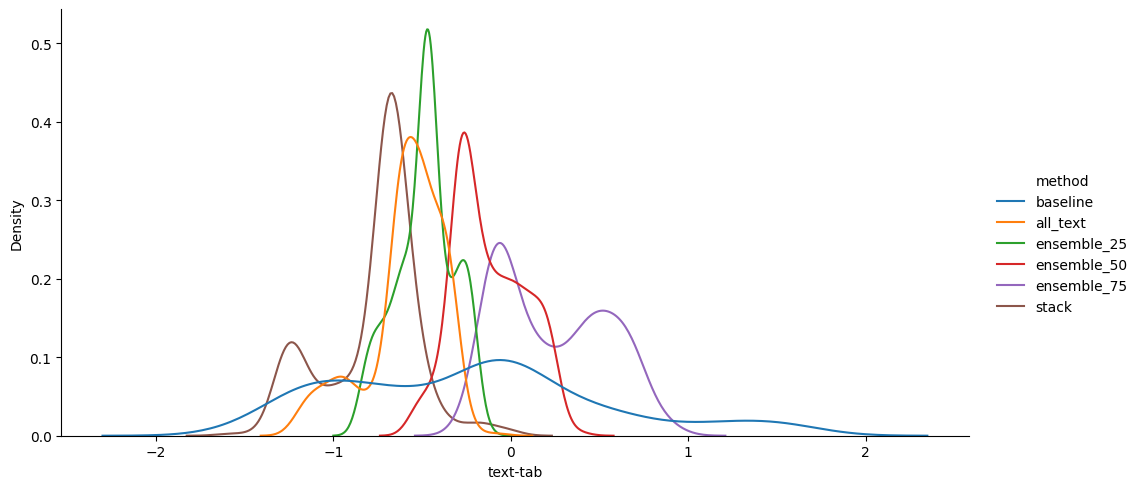

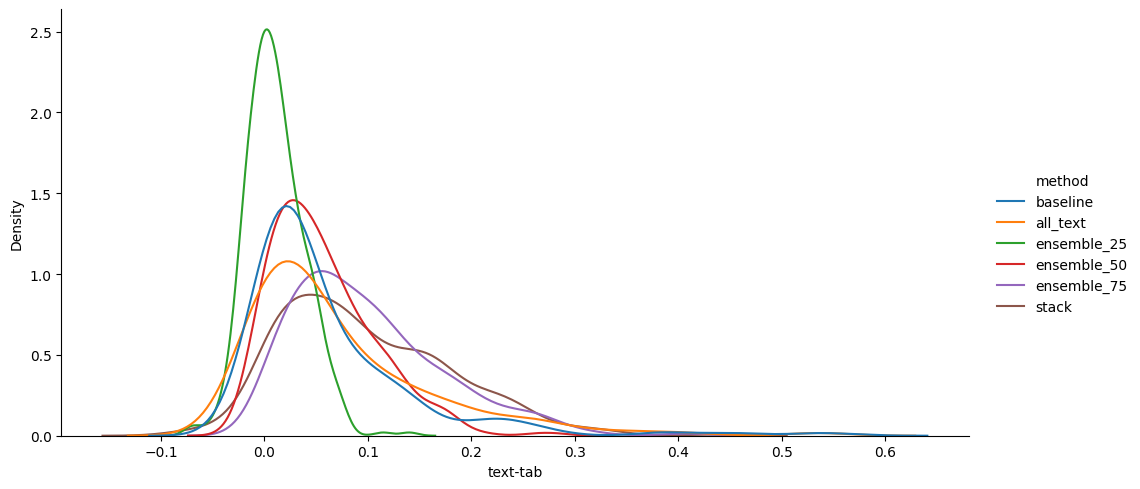

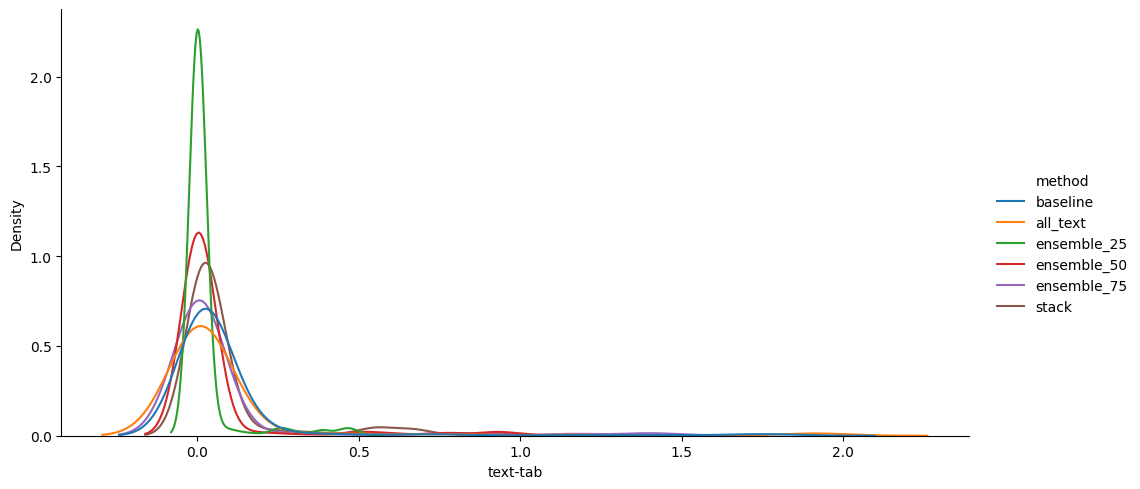

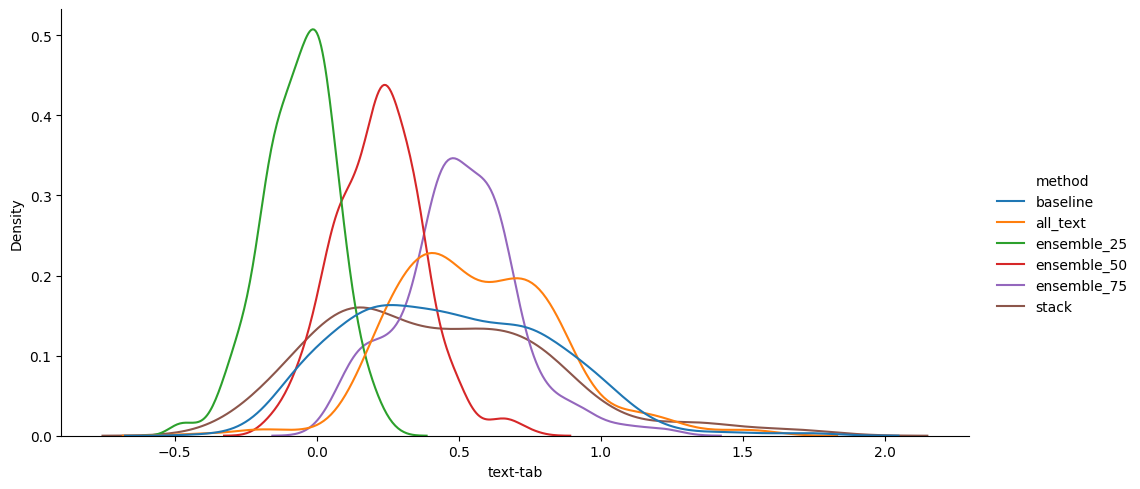

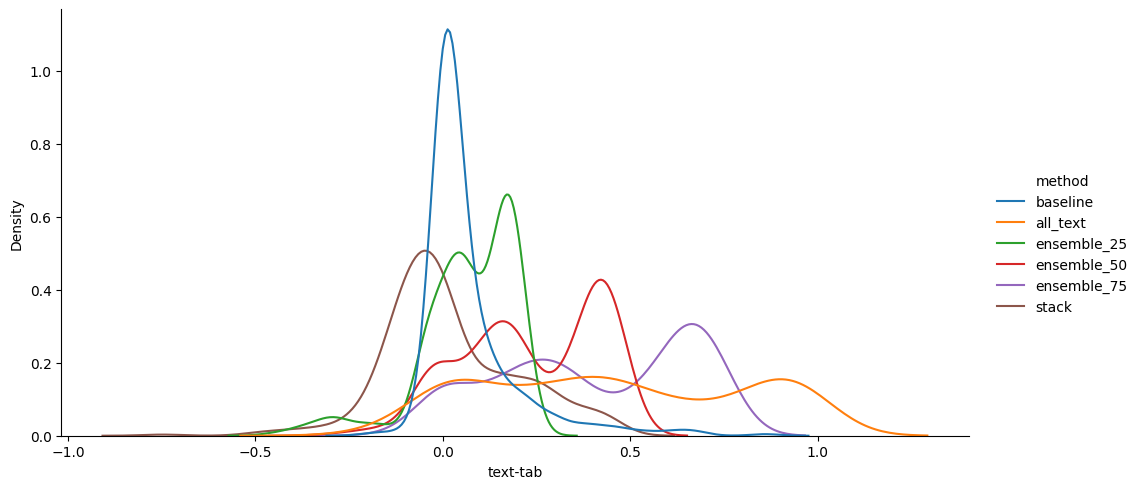

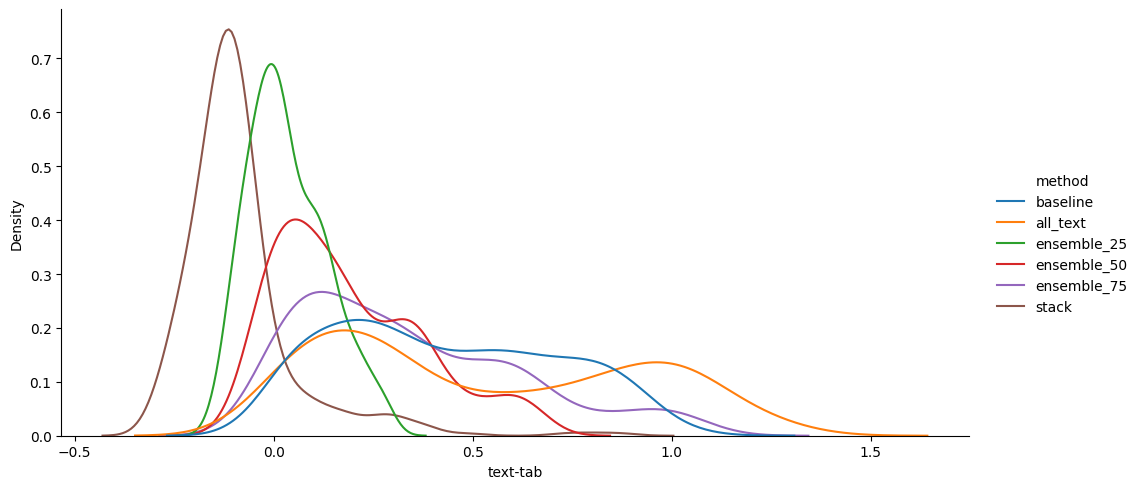

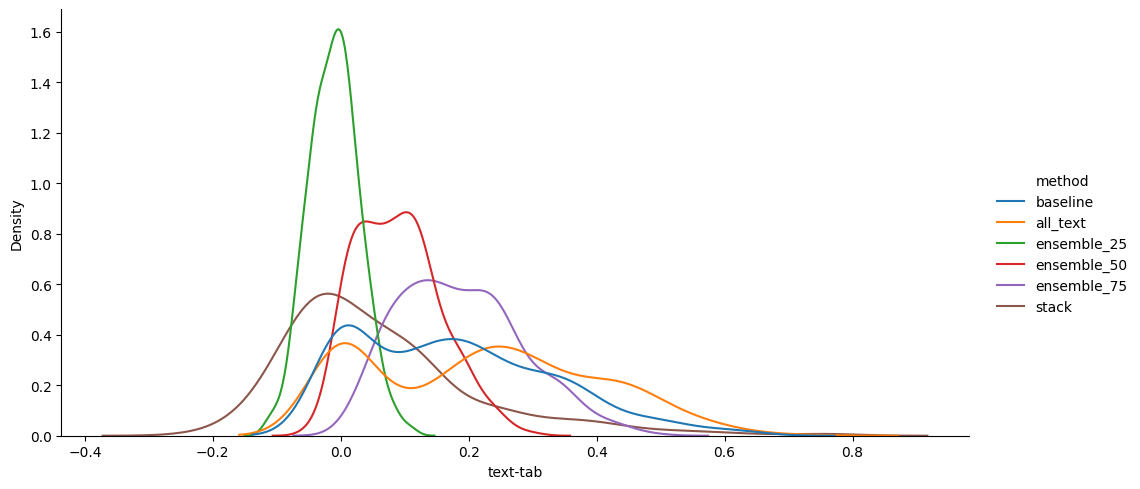

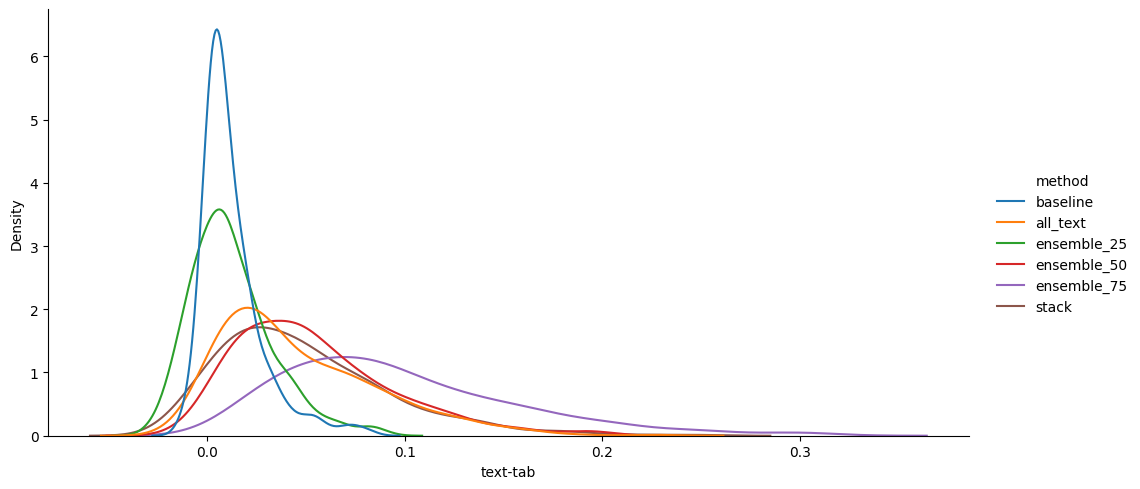

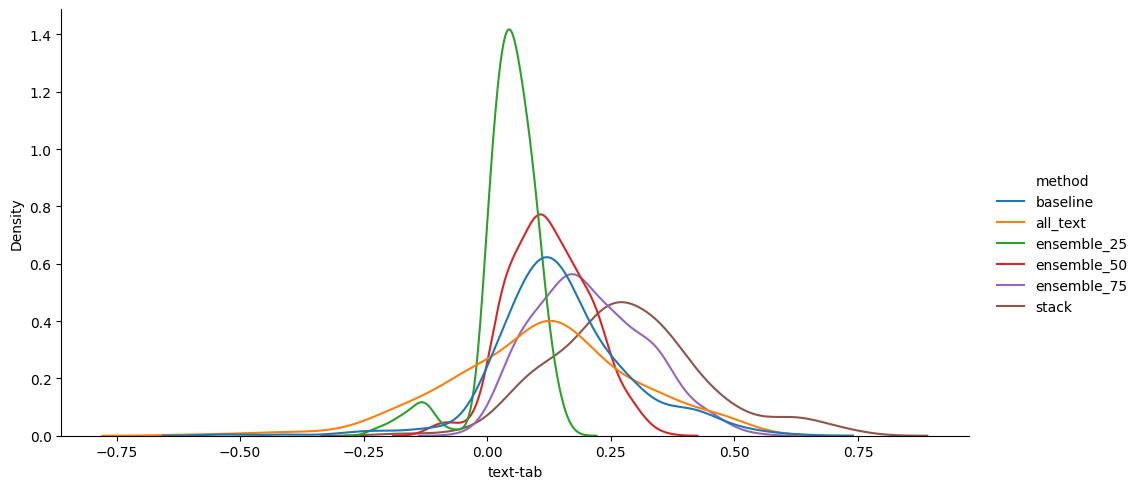

In [5]:
# instance_df[['text_model','text-tab']].plot.kde( figsize=(10,10))
# sns.displot(
#     instance_df, x='text-tab', kind="kde", hue="ds_name", bw_adjust=0.01, height=5, aspect=2
# )
# sns.displot(
#     insta
import math
import numpy as np
from scipy.stats import shapiro
from scipy.stats import lognorm

# #make this example reproducible
# np.random.seed(1)

# #generate dataset that contains 1000 log-normal distributed values
# lognorm_dataset = lognorm.rvs(s=.5, scale=math.exp(1), size=1000)

# #perform Shapiro-Wilk test for normality
# shapiro(instance_df[instance_df['ds_name']==ds_name])

# ShapiroResult(statistic=0.8573324680328369, pvalue=3.880663073872444e-29)
for ds_name in instance_df["ds_name"].unique():
    # set header
    # plt.figure()
    # plt.title(f"{ds_name}")
    print(shapiro(instance_df[instance_df["ds_name"] == ds_name]["text-tab"]))
    sns.displot(
        instance_df[instance_df["ds_name"] == ds_name],
        x="text-tab",
        kind="kde",
        hue="method",
        height=5,
        aspect=2,

    )

We to see for each of the datasets, for a given instance, whether different text models apply the same importance to each feature category (text, tabular or template). We do this by comparing the median feature importance of each category for each instance. We compare median feature importance because the distribution of feature importance is skewed. We compare text-tabular and text:template ratios.

## Kruskal-Wallis test

We do the kruskal-wallis test to see if methods assign the same importance to tabular and text features. We do this for each dataset. 

In [9]:
for ds in instance_df["ds_name"].unique():
    df = instance_df[instance_df["ds_name"] == ds][["method", "text-tab"]]
    print(
        ds,
        " ",
        stats.kruskal(
            *[
                df[df["method"] == method]["text-tab"].values
                for method in instance_df["method"].unique()
            ]
        ),
    )

prod_sent   KruskalResult(statistic=1336.3928369073813, pvalue=8.330617872257005e-287)
kick   KruskalResult(statistic=528.208502446897, pvalue=6.493400638156926e-112)
jigsaw   KruskalResult(statistic=356.039100255455, pvalue=8.766197952566392e-75)
wine   KruskalResult(statistic=1048.1532365889216, pvalue=2.2548361562801766e-224)
fake   KruskalResult(statistic=846.0464920012203, pvalue=1.2612110002657887e-180)
imdb_genre   KruskalResult(statistic=1278.5017673573493, pvalue=2.9024058702492183e-274)
channel   KruskalResult(statistic=875.9622012390664, pvalue=4.2389491059112886e-187)
airbnb   KruskalResult(statistic=952.9570012911281, pvalue=9.179344524877084e-204)
salary   KruskalResult(statistic=738.4711204185751, pvalue=2.3556776416626247e-157)


In [10]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st

In [256]:
# instance_df[["ds_name", "method", "text-tab"]].to_csv("instance_df.csv", index=False)

In [12]:
instance_df

ds_name text_model       method  tab_median  text_median  \
0      prod_sent    disbert     baseline    1.034273     0.374486   
1      prod_sent    disbert     all_text    0.682697     0.180244   
2      prod_sent    disbert  ensemble_25    0.500898     0.274237   
3      prod_sent    disbert  ensemble_50    0.333932     0.548475   
4      prod_sent    disbert  ensemble_75    0.166966     0.822712   
...          ...        ...          ...         ...          ...   
21595     salary    deberta     all_text    0.152978     0.123112   
21596     salary    deberta  ensemble_25    0.017799     0.035493   
21597     salary    deberta  ensemble_50    0.011866     0.070987   
21598     salary    deberta  ensemble_75    0.005933     0.106480   
21599     salary    deberta        stack    0.022428     0.323019   

       template_median  text-tab  
0             0.068839 -0.659788  
1             0.000000 -0.502453  
2             0.000000 -0.226661  
3             0.000000  0.214542  
4             0.000000  0.655746  
...                ...       ...  
21595         0.000000 -0.029866  
21596         0.000000  0.017694  
21597         0.000000  0.059121  
21598         0.000000  0.100547  
21599         0.000000  0.300590  

[21600 rows x 7 columns]

In [17]:
text_model_names = ["disbert", "bert", "drob", "deberta"]

ds_names = [
    "prod_sent",
    "kick",
    "jigsaw",
    "wine",
    "fake",
    "imdb_genre",
    "channel",
    "airbnb",
    "salary",
]
for ds in ds_names:
    prod = instance_df[instance_df["ds_name"]
                       == ds][["text_model", "text-tab"]]
    print(
        ds,
        " ",
        stats.kruskal(
            *[
                prod[prod["text_model"] == text_model]["text-tab"].values
                for text_model in text_model_names
            ]
        ),
    )
print(
    "Overall ",
    stats.kruskal(
        *[
            instance_df[instance_df["text_model"]
                        == text_model]["text-tab"].values
            for text_model in text_model_names
        ]
    ),
)

# template
# print("\ntemplate")
# for ds in ds_names:
#     prod = instance_df[instance_df["ds_name"] == ds][["text_model", "text:template"]]
#     print(
#         ds,
#         " ",
#         stats.kruskal(
#             *[
#                 prod[prod["text_model"] == text_model]["text:template"].values
#                 for text_model in text_model_names
#             ]
#         ),
#     )
# print(
#     "Overall ",
#     stats.kruskal(
#         *[
#             instance_df[instance_df["text_model"] == text_model]["text:template"].values
#             for text_model in text_model_names
#         ]
#     ),
# )

prod_sent   KruskalResult(statistic=34.27090866839595, pvalue=1.7367161195407492e-07)
kick   KruskalResult(statistic=92.27102778703374, pvalue=7.123708392698308e-20)
jigsaw   KruskalResult(statistic=220.10525093591949, pvalue=1.905316601611993e-47)
wine   KruskalResult(statistic=44.16332898792098, pvalue=1.3933031416782083e-09)
fake   KruskalResult(statistic=177.1768632312727, pvalue=3.5901064365646895e-38)
imdb_genre   KruskalResult(statistic=12.451883506872036, pvalue=0.005985137340566363)
channel   KruskalResult(statistic=424.52287862696085, pvalue=1.0787932601603853e-91)
airbnb   KruskalResult(statistic=8.990269311397242, pvalue=0.02942054149334799)
salary   KruskalResult(statistic=9.809726884631345, pvalue=0.020254736318818613)
Overall  KruskalResult(statistic=120.60611151507418, pvalue=5.713438319938125e-26)


In [4]:
agg_df = pd.read_csv("../models/shap_vals_all_text_baseline_agg_df.csv")

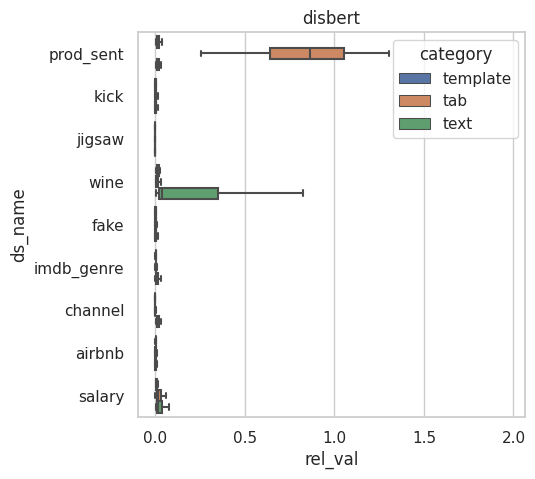

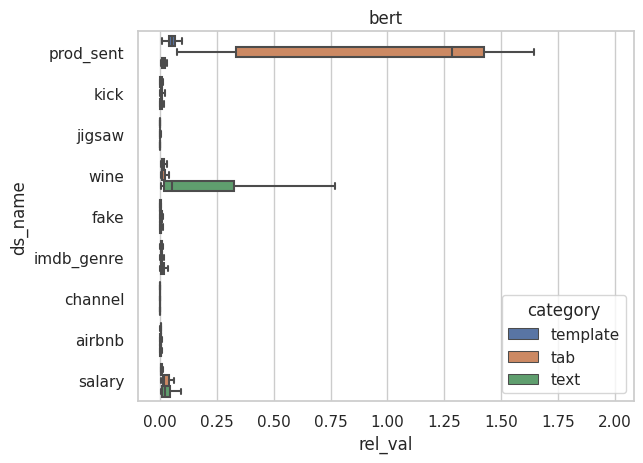

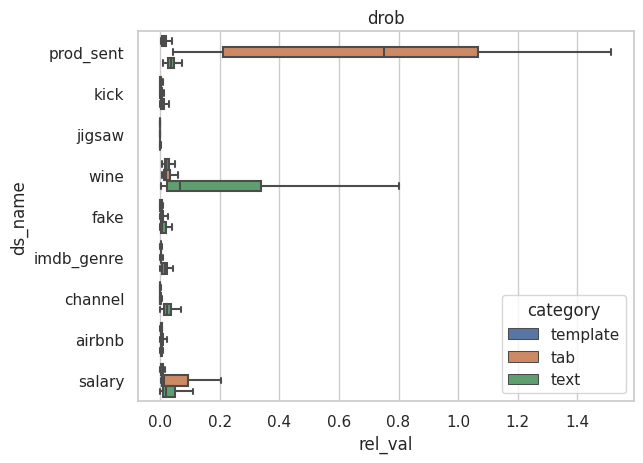

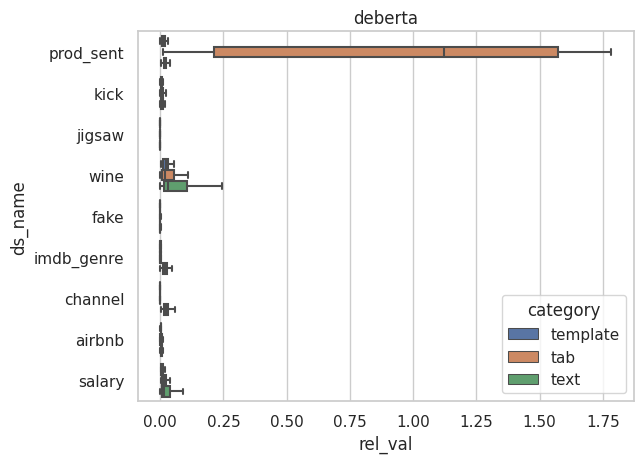

In [19]:
# plot value vs rel_ft_len
sns.set_theme(style="whitegrid")
# 2x2 grid of plots
# fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(10, 10))
plt.figure(figsize=(5, 5))
for text_model in ["disbert", "bert", "drob", "deberta"]:
    ax = sns.boxplot(
        x="rel_val",
        y="ds_name",
        hue="category",
        data=agg_df[agg_df["text_model"] == text_model],
        fliersize=0,
    )
    plt.title(f"{text_model}")
    plt.show()

# def fixed_boxplot(x, y, *args, label=None, **kwargs):
#     sns.boxplot(x=x, y=y, *args, **kwargs, labels=[label])
# g = sns.FacetGrid(data=agg_df, col="text_model", hue="category", col_wrap=5)

# # # Define the scatterplot for each subplot
# g.map(fixed_boxplot, "value", "ds_name")

# # Adjust the layout of the subplots
# # g.tight_layout()
# # plt.xscale("log")
# # plt.yscale("log")
# # Display the plot

# # plt.rcParams["figure.figsize"] = (30, 20)
# plt.show()
# add this to make plots bigger:
# plt.rcParams["figure.figsize"] = (20, 20)

In [5]:
my_df = pd.read_csv("../models/shap_vals_all_text_baseline_df.csv")

In [24]:
my_df["label_sum"].max()

0.9987607911643864

In [25]:
# This code plots a

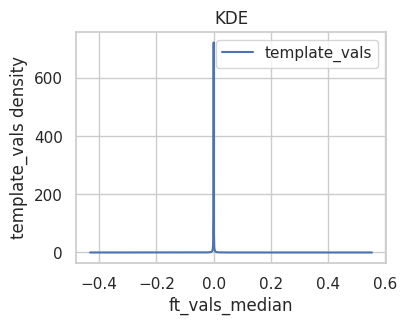

In [26]:
# Set up the figure and axes
fig, ax = plt.subplots(figsize=(4, 3))

# Plot the KDE on a logarithmic scale
my_df.plot.kde(x="ft_vals_median", y="template_vals", ax=ax)

# Set the y-axis scale to logarithmic
# ax.set_xscale('log')

# Add labels and title
ax.set_xlabel("ft_vals_median")
ax.set_ylabel("template_vals density")
ax.set_title("KDE")

# Display the plot
plt.show()

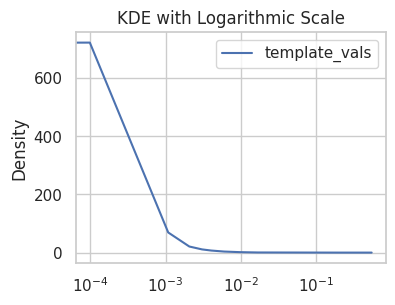

In [27]:
# Set up the figure and axes
fig, ax = plt.subplots(figsize=(4, 3))

y_col = "template_vals"
x_col = "ft_vals_median"
# Plot the KDE on a logarithmic scale
my_df.plot.kde(x=x_col, y=y_col, ax=ax)

# Set the y-axis scale to logarithmic
ax.set_xscale("log")

# Add labels and title
# ax.set_xlabel(x_col)
# ax.set_ylabel(f"{y_col} density")
ax.set_title("KDE with Logarithmic Scale")

# Display the plot
plt.show()

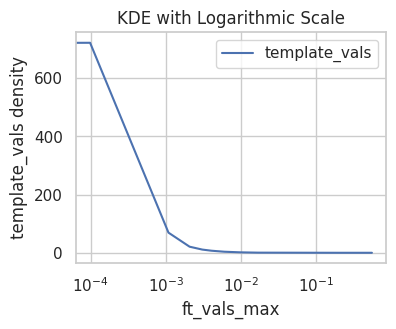

In [28]:
# Set up the figure and axes
fig, ax = plt.subplots(figsize=(4, 3))

y_col = "template_vals"
x_col = "ft_vals_max"
# Plot the KDE on a logarithmic scale
my_df.plot.kde(x=x_col, y=y_col, ax=ax)

# Set the y-axis scale to logarithmic
ax.set_xscale("log")

# Add labels and title
ax.set_xlabel(x_col)
ax.set_ylabel(f"{y_col} density")
ax.set_title("KDE with Logarithmic Scale")

# Display the plot
plt.show()

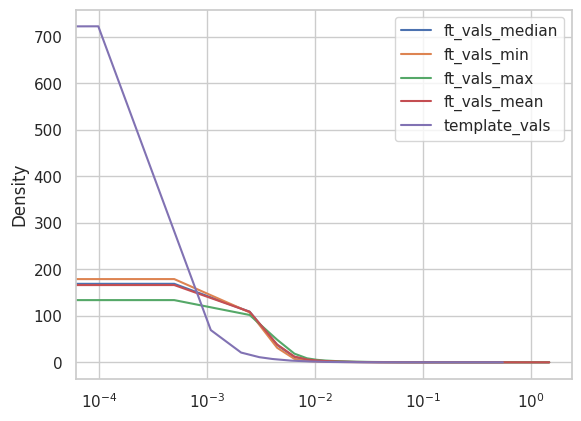

In [29]:
cols = [
    "ft_vals_median",
    "ft_vals_min",
    "ft_vals_max",
    "ft_vals_mean",
    "template_vals",
]
my_df[cols].plot.kde(
    # x=x_col,
    # y="template_vals",
    # ax=ax,
)
plt.xscale("log")
plt.show()

In [30]:
from scipy.stats import ks_2samp
import numpy as np

x_cols = ["ft_vals_median", "ft_vals_min", "ft_vals_max"]
y_col = "template_vals"

# Calculate the KS statistic for each x-axis column
for x_col in x_cols:
    ks_stat, p_value = ks_2samp(
        my_df[x_col], my_df[y_col], alternative="two-sided", mode="auto"
    )
    print(f"KS Statistic for {x_col}: {ks_stat}, p-value: {p_value}")
    # scipy.stats.ks_2samp(data1, data2, alternative='two-sided', mode='auto')

KS Statistic for ft_vals_median: 0.549690625, p-value: 0.0
KS Statistic for ft_vals_min: 0.549690625, p-value: 0.0
KS Statistic for ft_vals_max: 0.55045625, p-value: 0.0


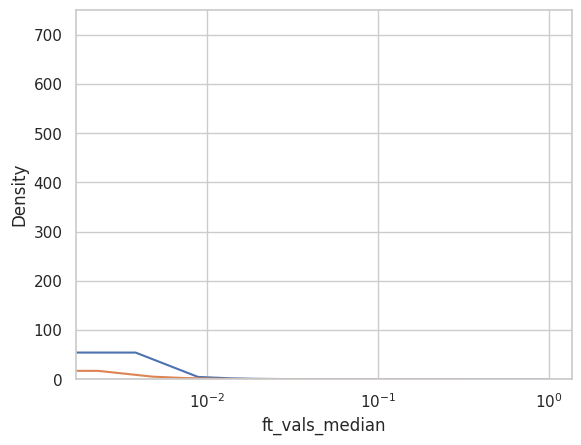

In [31]:
sns.kdeplot(data=(my_df), x="ft_vals_median")
sns.kdeplot(data=(my_df), x="template_vals")
plt.xscale("log")

In [34]:
my_df

Unnamed: 0  abs_template_vals  template_vals  abs_ft_vals_sum  \
0                0           0.001363      -0.001363         0.003093   
1                1           0.001969      -0.001969         0.071347   
2                2           0.002132       0.002132         0.050701   
3                3           0.002319      -0.002319         0.115896   
4                4           0.011435      -0.011435         0.514044   
...            ...                ...            ...              ...   
319995      319995           0.025310       0.025310         0.051397   
319996      319996           0.001859       0.001859         0.001859   
319997      319997           0.001492      -0.001492         0.008879   
319998      319998           0.000590       0.000590         0.010741   
319999      319999           0.000599       0.000599         0.000880   

        ft_vals_sum  ft_vals_mean  ft_vals_median  ft_vals_max  ft_vals_min  \
0          0.003093      0.003093        0.003093     0.003093     0.003093   
1         -0.071347      0.002932        0.001549     0.015131     0.000097   
2         -0.050701      0.050701        0.050701     0.050701     0.050701   
3         -0.115896      0.005834        0.002114     0.028522     0.000051   
4          0.514044      0.514044        0.514044     0.514044     0.514044   
...             ...           ...             ...          ...          ...   
319995     0.051397      0.012849        0.003716     0.043114     0.000850   
319996     0.001859      0.001859        0.001859     0.001859     0.001859   
319997    -0.008879      0.001480        0.001393     0.001752     0.001294   
319998    -0.010741      0.000845        0.000797     0.001742     0.000176   
319999     0.000880      0.000515        0.000283     0.001190     0.000283   

       tab_or_text  label  ft_num  example_num    ds_name text_model  \
0              tab      0       0            0  prod_sent    disbert   
1             text      0       1            0  prod_sent    disbert   
2              tab      1       0            0  prod_sent    disbert   
3             text      1       1            0  prod_sent    disbert   
4              tab      2       0            0  prod_sent    disbert   
...            ...    ...     ...          ...        ...        ...   
319995        text      5       1           99     salary    deberta   
319996        text      5       2           99     salary    deberta   
319997        text      5       3           99     salary    deberta   
319998        text      5       4           99     salary    deberta   
319999        text      5       5           99     salary    deberta   

        label_sum  total_length  
0       -0.082323            37  
1       -0.082323            37  
2       -0.173341            37  
3       -0.173341            37  
4        0.575669            37  
...           ...           ...  
319995   0.084573            61  
319996   0.084573            61  
319997   0.084573            61  
319998   0.084573            61  
319999   0.084573            61  

[320000 rows x 17 columns]

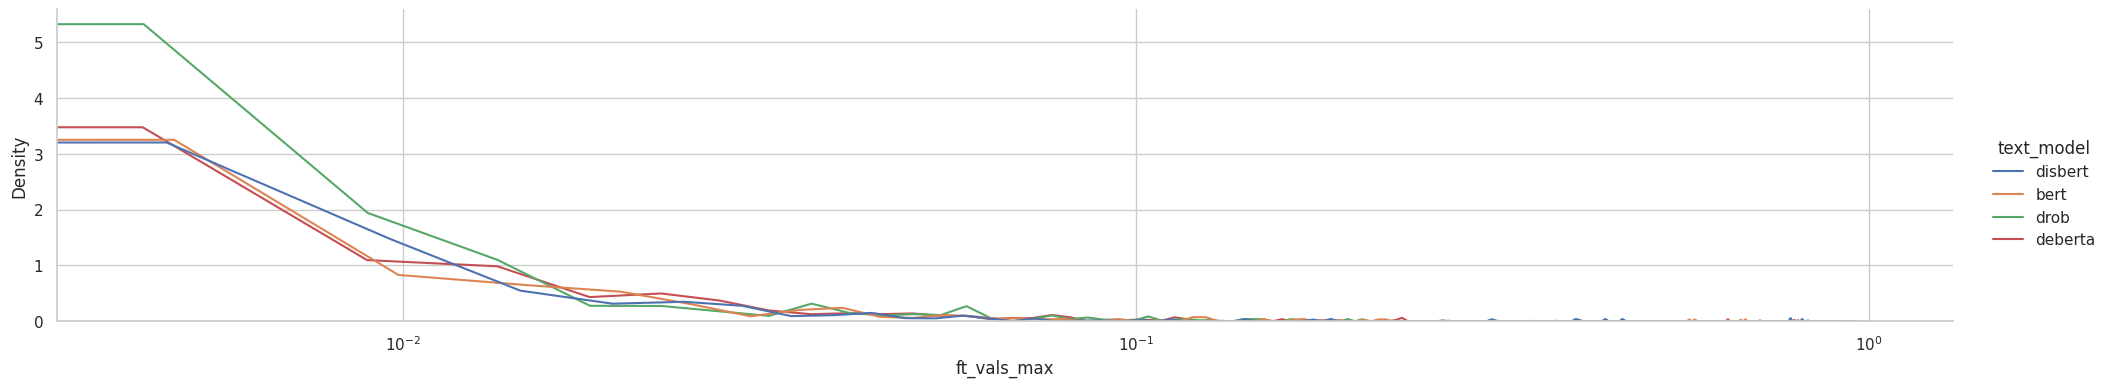

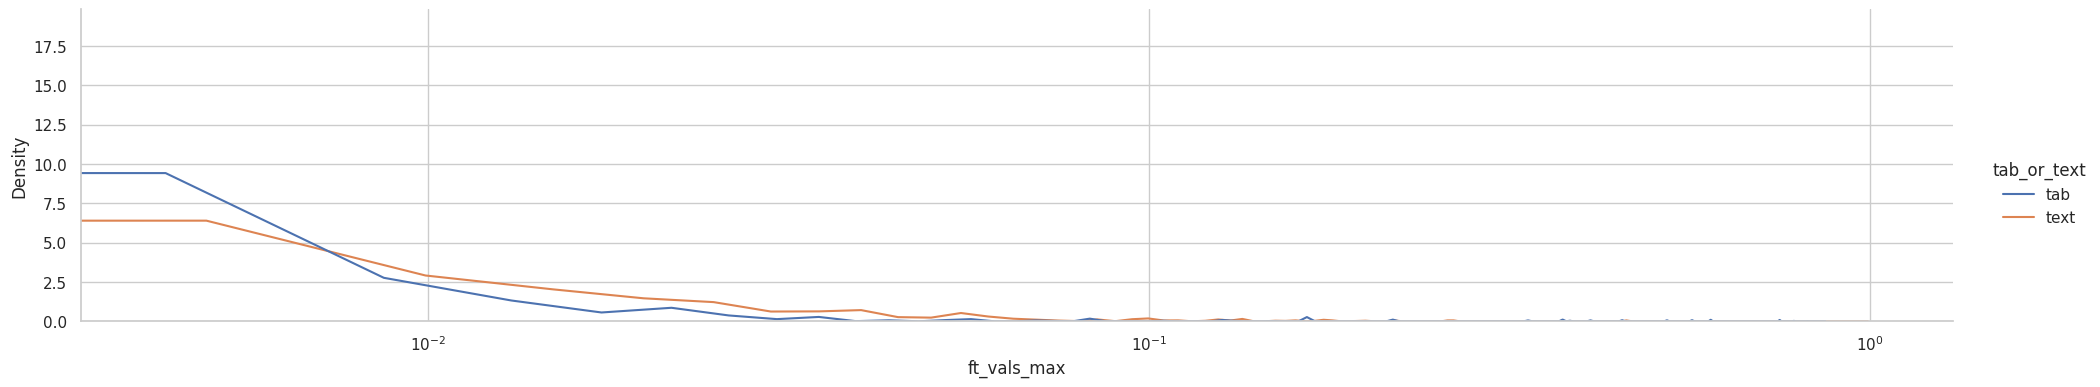

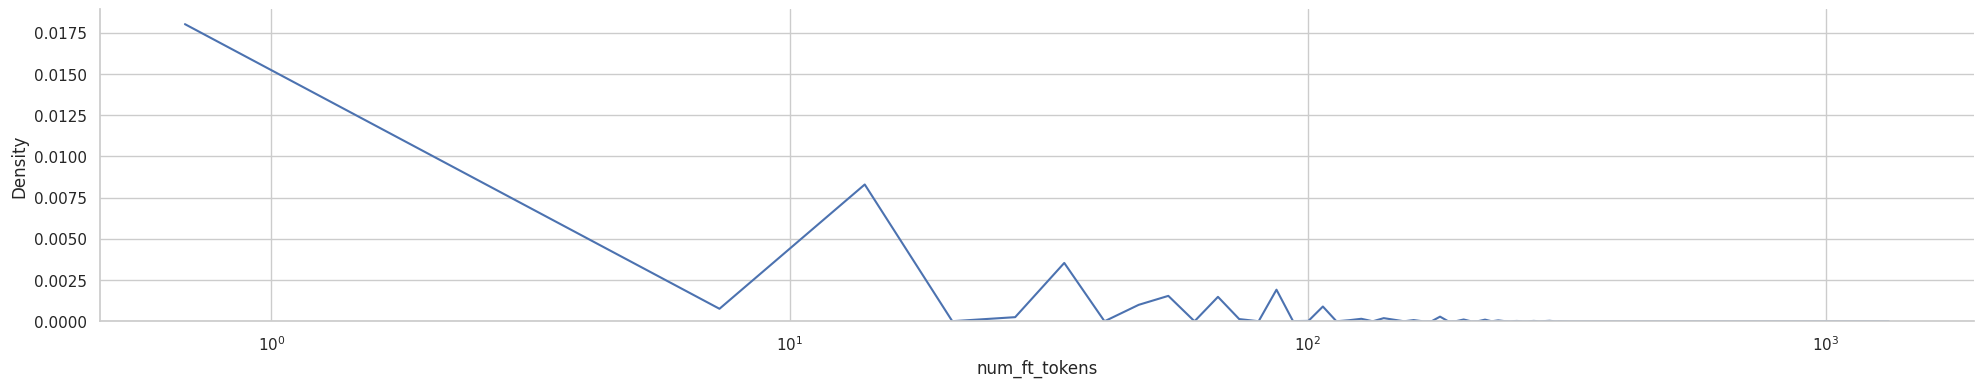

In [44]:
sns.displot(
    my_df, x=x_col, kind="kde", hue="text_model", bw_adjust=0.01, height=4, aspect=5
)
plt.xscale("log")
sns.displot(
    my_df, x=x_col, kind="kde", hue="tab_or_text", bw_adjust=0.005, height=4, aspect=5
)
plt.xscale("log")
sns.displot(my_df, x="num_ft_tokens", kind="kde",
            bw_adjust=0.05, height=4, aspect=5)
plt.xscale("log")
# reduce plot area
# sns.displot(my_df, x='num_ft_tokens', kind='kde', bw_adjust=0.1,  height=4, aspect=2)

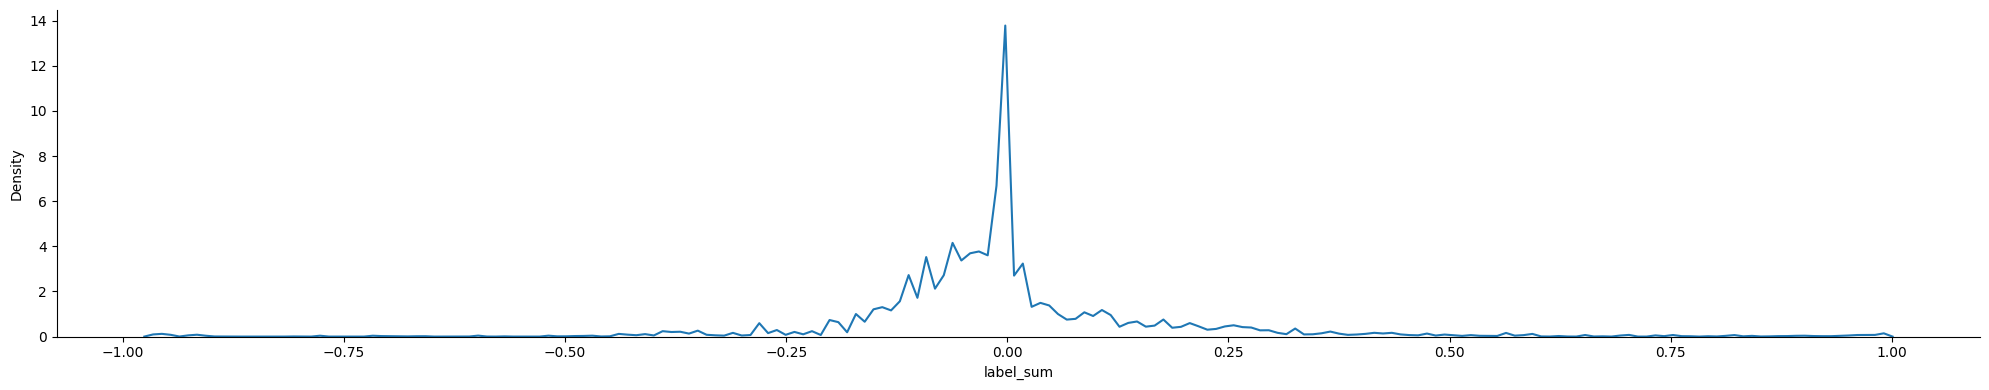

In [72]:
sns.displot(my_df, x="label_sum", kind="kde",
            bw_adjust=0.05, height=4, aspect=5)
# plt.xscale('log')

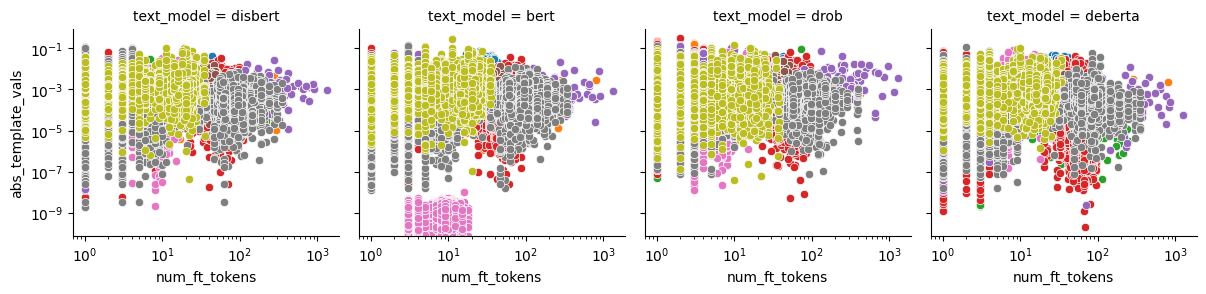

In [73]:
# sns.scatterplot(data=my_df, x="num_ft_tokens", y='abs_template_vals', hue='ds_name')#, alpha=0.01)
# Set plot size
# Create a FacetGrid with the desired variables
g = sns.FacetGrid(data=my_df, col="text_model", hue="ds_name", col_wrap=5)

# # Define the scatterplot for each subplot
g.map(sns.scatterplot, "num_ft_tokens", "abs_template_vals")

# Adjust the layout of the subplots
g.tight_layout()
plt.xscale("log")
plt.yscale("log")
# Display the plot
plt.show()

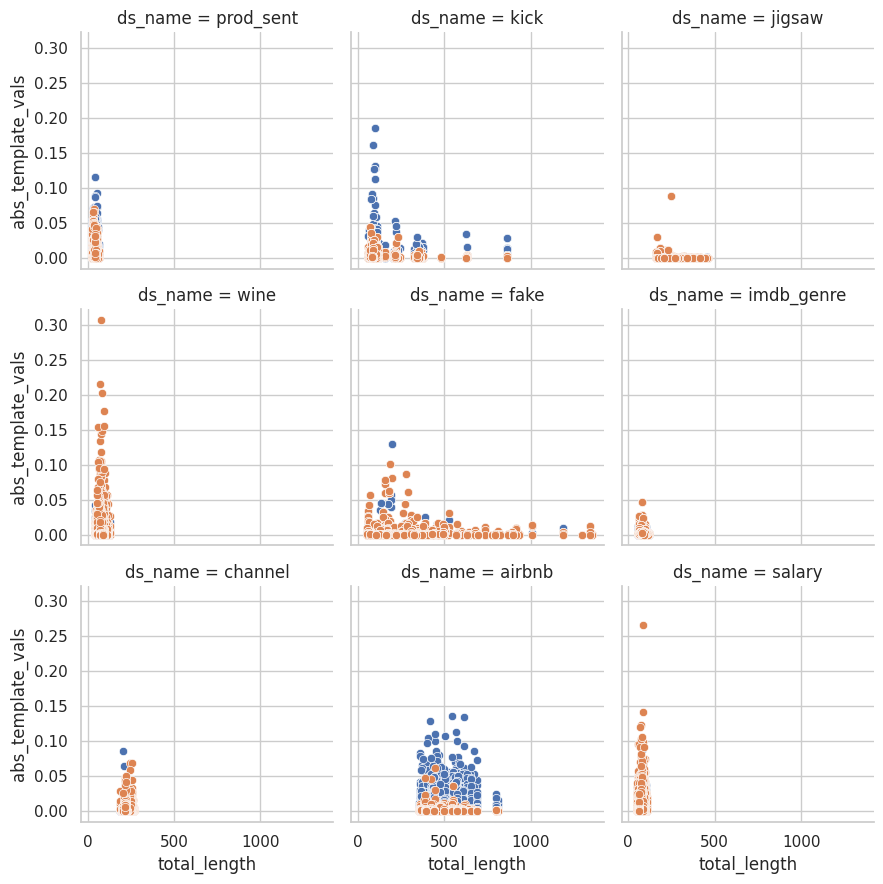

In [45]:
# sns.scatterplot(data=my_df, x="num_ft_tokens", y='abs_template_vals', hue='ds_name')#, alpha=0.01)
# Set plot size
# Create a FacetGrid with the desired variables
g = sns.FacetGrid(data=my_df, col="ds_name", hue="tab_or_text", col_wrap=3)

# # Define the scatterplot for each subplot
g.map(sns.scatterplot, "total_length", "abs_template_vals")

# Adjust the layout of the subplots
g.tight_layout()
# plt.xscale("log")
# plt.yscale("log")
# Display the plot
plt.show()

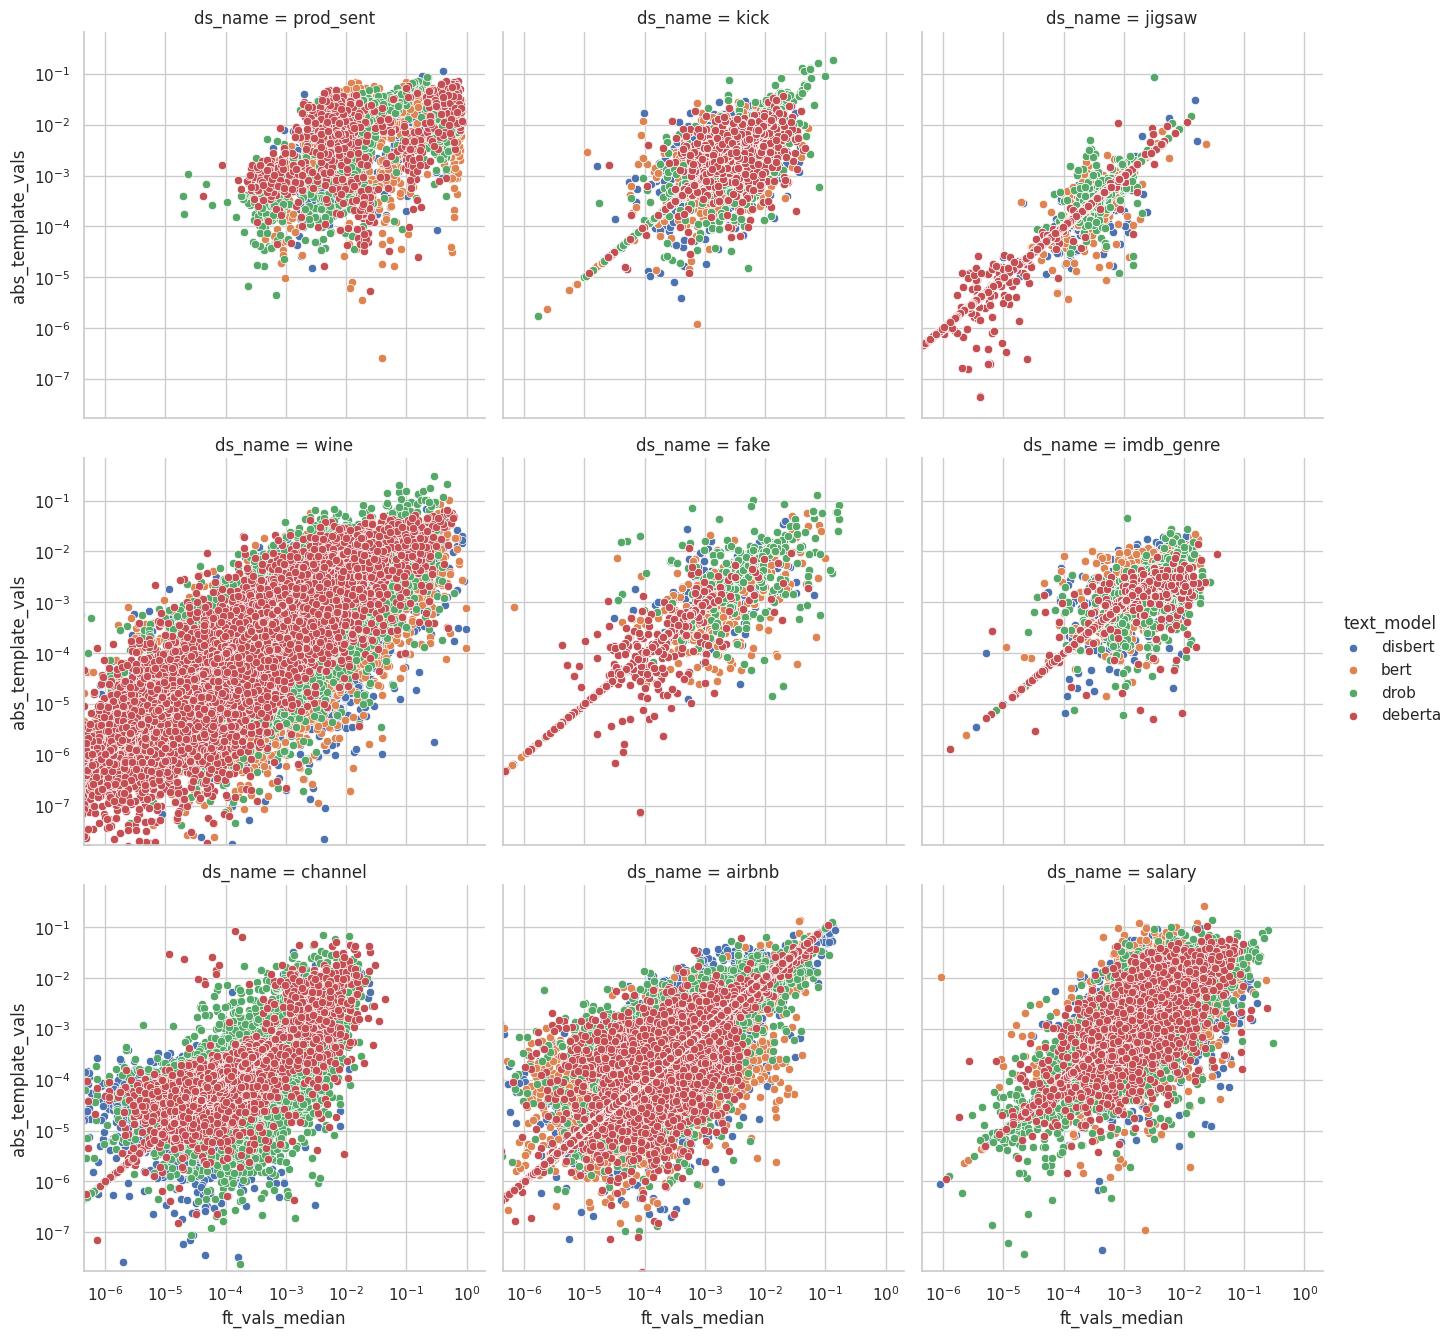

In [52]:
# sns.scatterplot(data=my_df, x="num_ft_tokens", y='abs_template_vals', hue='ds_name')#, alpha=0.01)
# Set plot size
# Create a FacetGrid with the desired variables
# my_df["log_num_ft_tokens"] = np.log(my_df["num_ft_tokens"])
# cmap = sns.cubehelix_palette(rot=-.2, as_cmap=True)
g = sns.FacetGrid(data=my_df, col="ds_name",  col_wrap=3,
                  height=4.5, hue="text_model")

# # Define the scatterplot for each subplot
g.map(sns.scatterplot, "ft_vals_median", "abs_template_vals")

# Adjust the layout of the subplots
g.tight_layout()
g.set(xscale="log")
g.set(yscale="log")
g.add_legend()

plt.show()

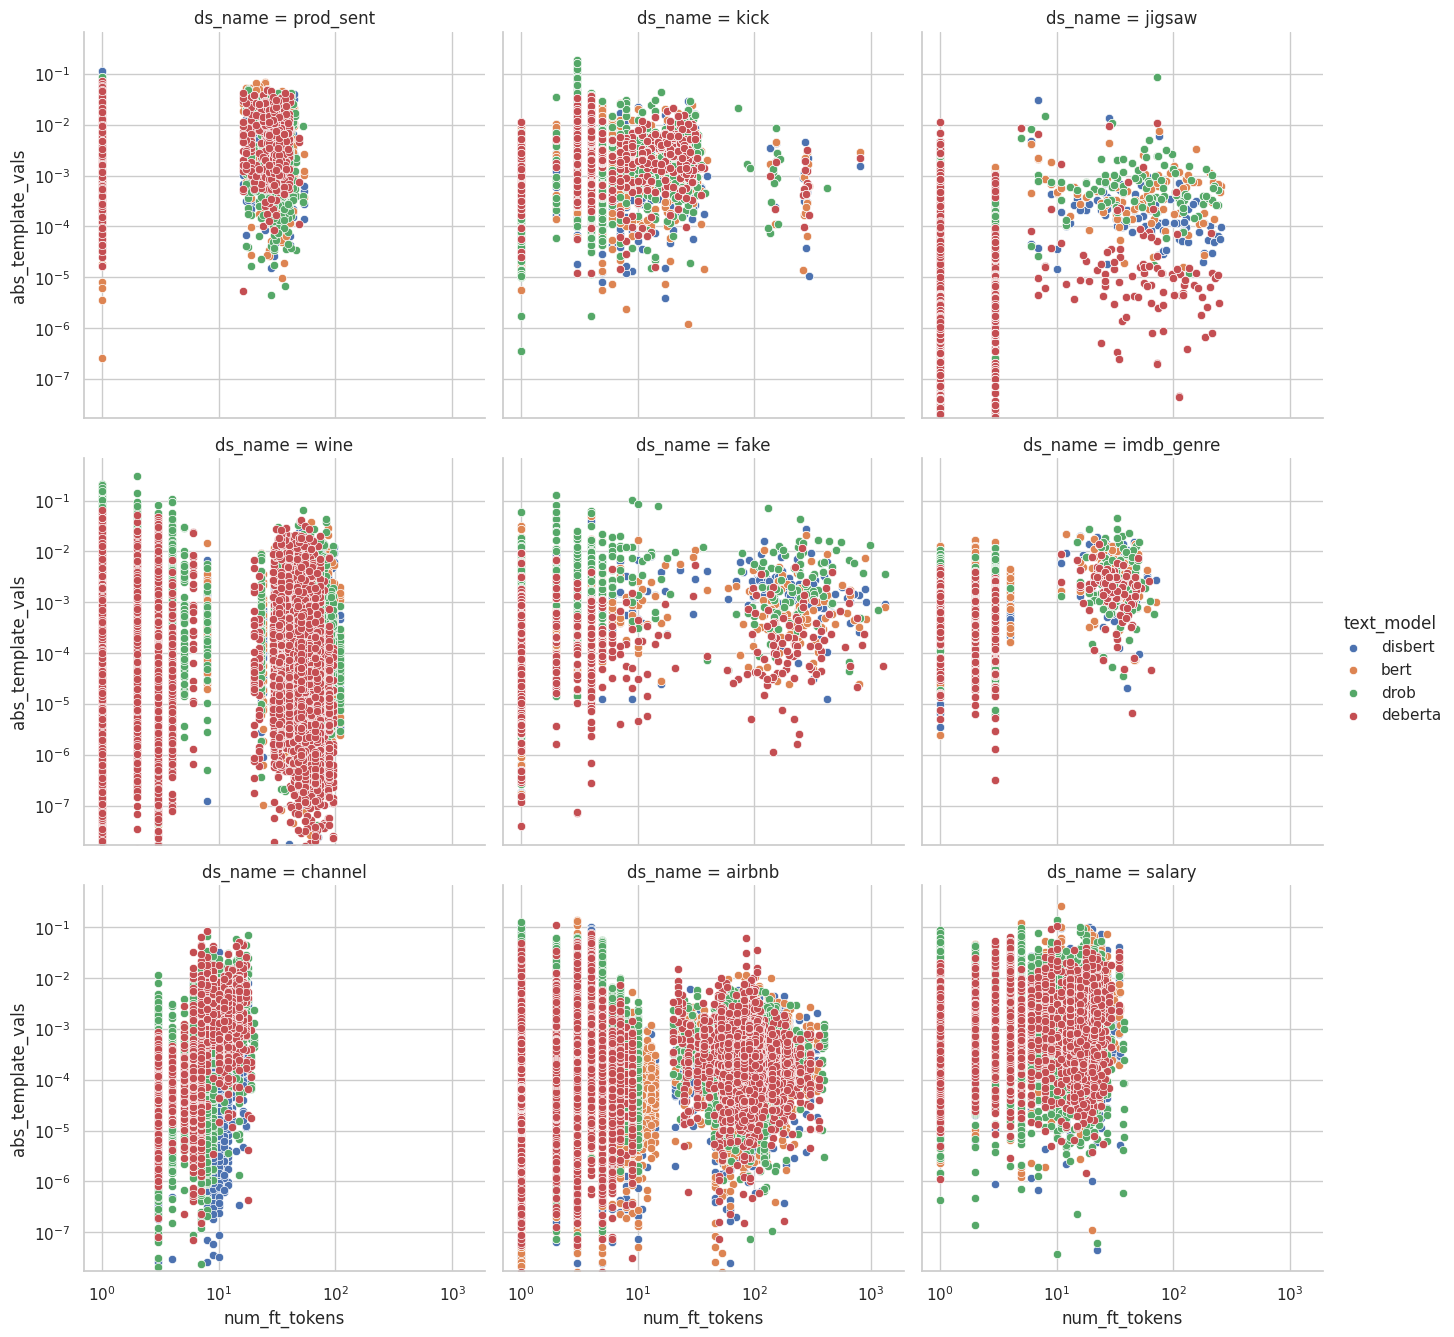

In [53]:
# sns.scatterplot(data=my_df, x="num_ft_tokens", y='abs_template_vals', hue='ds_name')#, alpha=0.01)
# Set plot size
# Create a FacetGrid with the desired variables
# my_df["log_num_ft_tokens"] = np.log(my_df["num_ft_tokens"])
cmap = sns.cubehelix_palette(rot=-.2, as_cmap=True)
g = sns.FacetGrid(data=my_df, col="ds_name",  col_wrap=3,
                  height=4.5, hue="text_model")  # hue="log_num_ft_tokens",

# # Define the scatterplot for each subplot
g.map(sns.scatterplot, "num_ft_tokens", "abs_template_vals")

# Adjust the layout of the subplots
g.tight_layout()
g.set(xscale="log")
g.set(yscale="log")
g.add_legend()

plt.show()

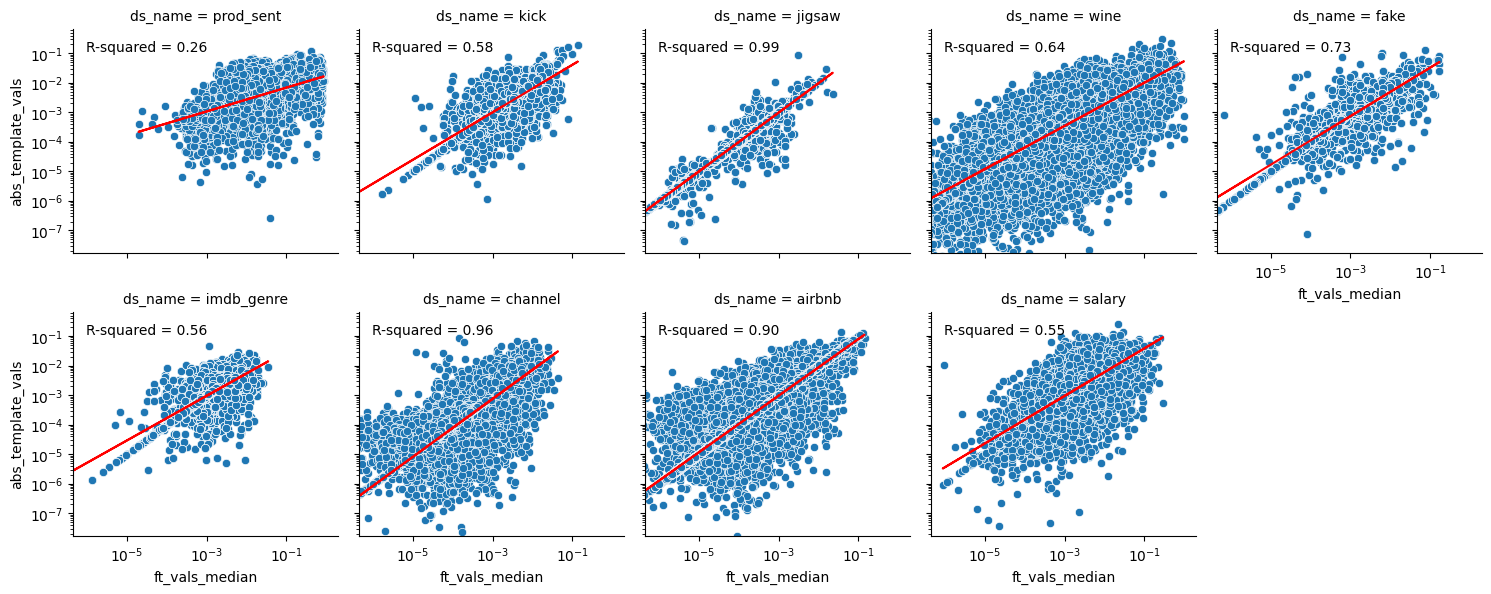

In [149]:
from scipy.stats import linregress

# Calculate the line of best fit and R-squared value


def add_regression_line(x, y, **kwargs):
    valid_mask = (x > 0) & (y > 0)
    log_x = np.log10(x[valid_mask])
    log_y = np.log10(y[valid_mask])

    if len(log_x) > 0 and len(log_y) > 0:
        slope, intercept, r_value, p_value, std_err = linregress(log_x, log_y)
        line = slope * log_x + intercept
        plt.plot(x[valid_mask], 10**line, color="r")
        plt.annotate(
            f"R-squared = {r_value**2:.2f}", xy=(0.05, 0.9), xycoords="axes fraction"
        )


# sns.scatterplot(data=my_df, x="num_ft_tokens", y='abs_template_vals', hue='ds_name')#, alpha=0.01)
# Set plot size
# Create a FacetGrid with the desired variables
my_df["log_num_ft_tokens"] = np.log(my_df["num_ft_tokens"])
# cmap = sns.cubehelix_palette(rot=-.2, as_cmap=True)
g = sns.FacetGrid(
    data=my_df,
    col="ds_name",
    #   hue="log_num_ft_tokens",
    col_wrap=5,
)

# Define the scatterplot and add the regression line
g.map(sns.scatterplot, "ft_vals_median", "abs_template_vals")
g.map(add_regression_line, "ft_vals_median", "abs_template_vals")

# Adjust the layout of the subplots
g.tight_layout()
g.set(xscale="log")
g.set(yscale="log")

# Show the plot
plt.show()

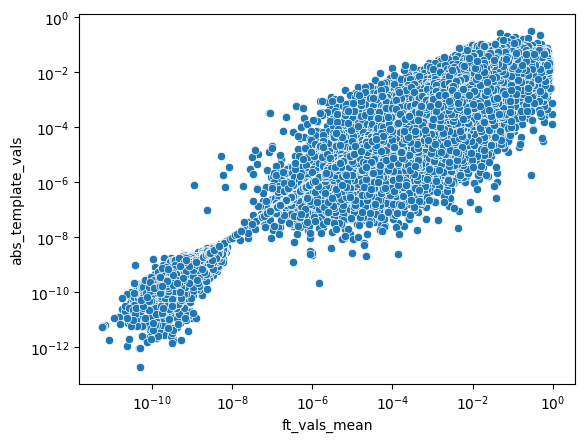

In [143]:
sns.scatterplot(data=my_df, x="ft_vals_mean", y="abs_template_vals")
plt.xscale("log")
plt.yscale("log")

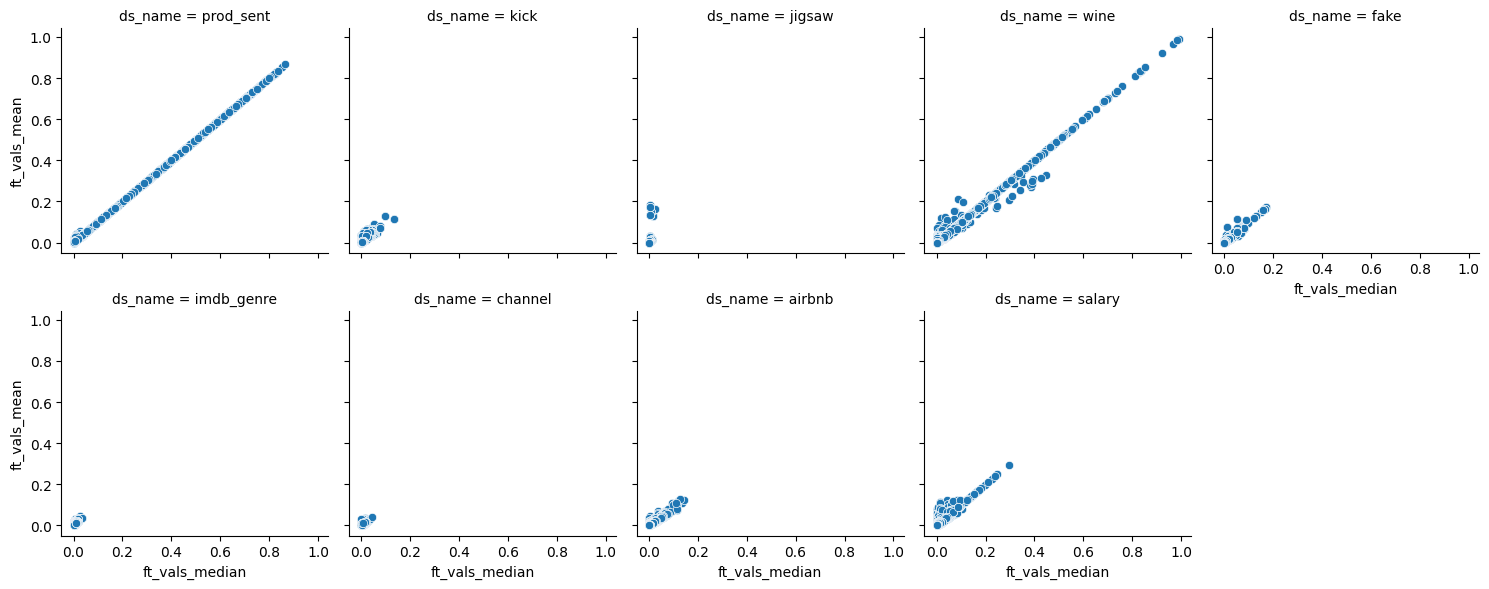

In [77]:
# sns.scatterplot(data=my_df, x="num_ft_tokens", y='abs_template_vals', hue='ds_name')#, alpha=0.01)
# Set plot size
# Create a FacetGrid with the desired variables
my_df["log_num_ft_tokens"] = np.log(my_df["num_ft_tokens"])
# cmap = sns.cubehelix_palette(rot=-.2, as_cmap=True)
g = sns.FacetGrid(data=my_df, col="ds_name", col_wrap=5)

# # Define the scatterplot for each subplot
g.map(sns.scatterplot, "ft_vals_median", "ft_vals_mean")

# Adjust the layout of the subplots
g.tight_layout()
# g.set(xscale="log")
# g.set(yscale="log")
# g.add_legend()

plt.show()

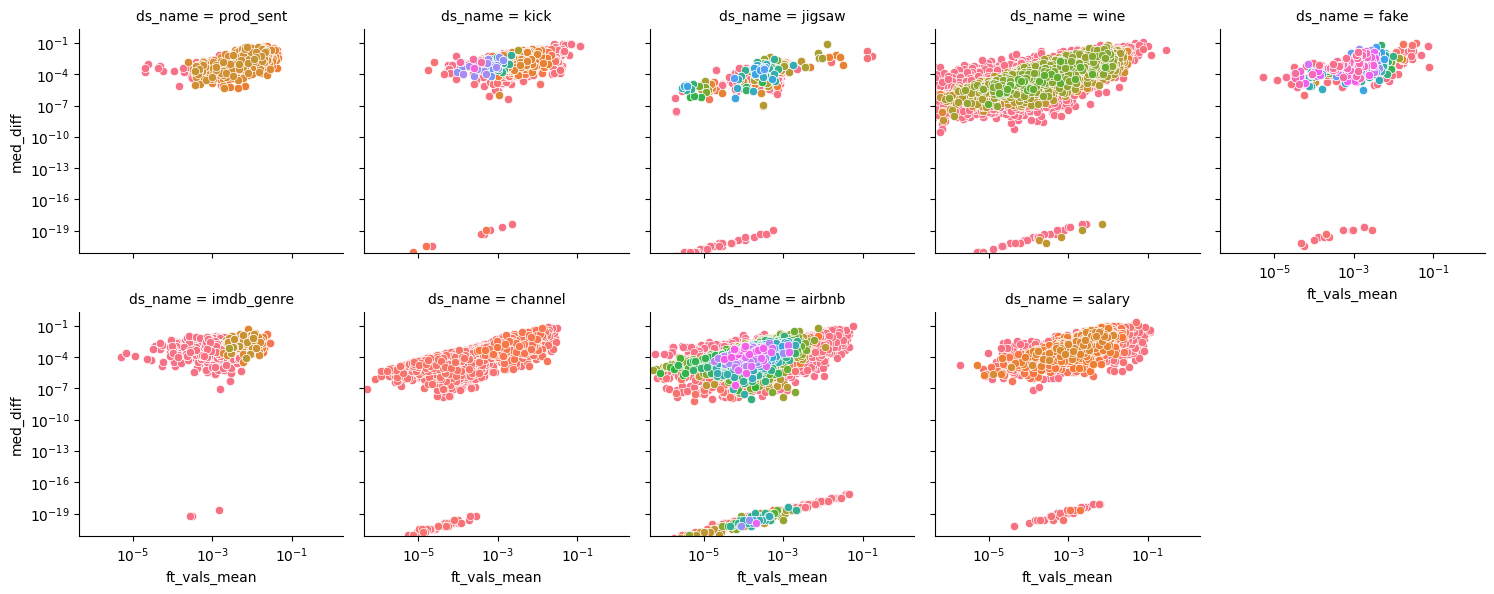

In [78]:
# sns.scatterplot(data=my_df, x="num_ft_tokens", y='abs_template_vals', hue='ds_name')#, alpha=0.01)
# Set plot size
# Create a FacetGrid with the desired variables
my_df["med_diff"] = my_df["abs_template_vals"] - my_df["ft_vals_median"]
# cmap = sns.cubehelix_palette(rot=-.2, as_cmap=True)
g = sns.FacetGrid(data=my_df, col="ds_name",
                  hue="log_num_ft_tokens", col_wrap=5)

# # Define the scatterplot for each subplot
g.map(sns.scatterplot, "ft_vals_mean", "med_diff")

# Adjust the layout of the subplots
g.tight_layout()
g.set(xscale="log")
g.set(yscale="log")
# g.add_legend()

plt.show()

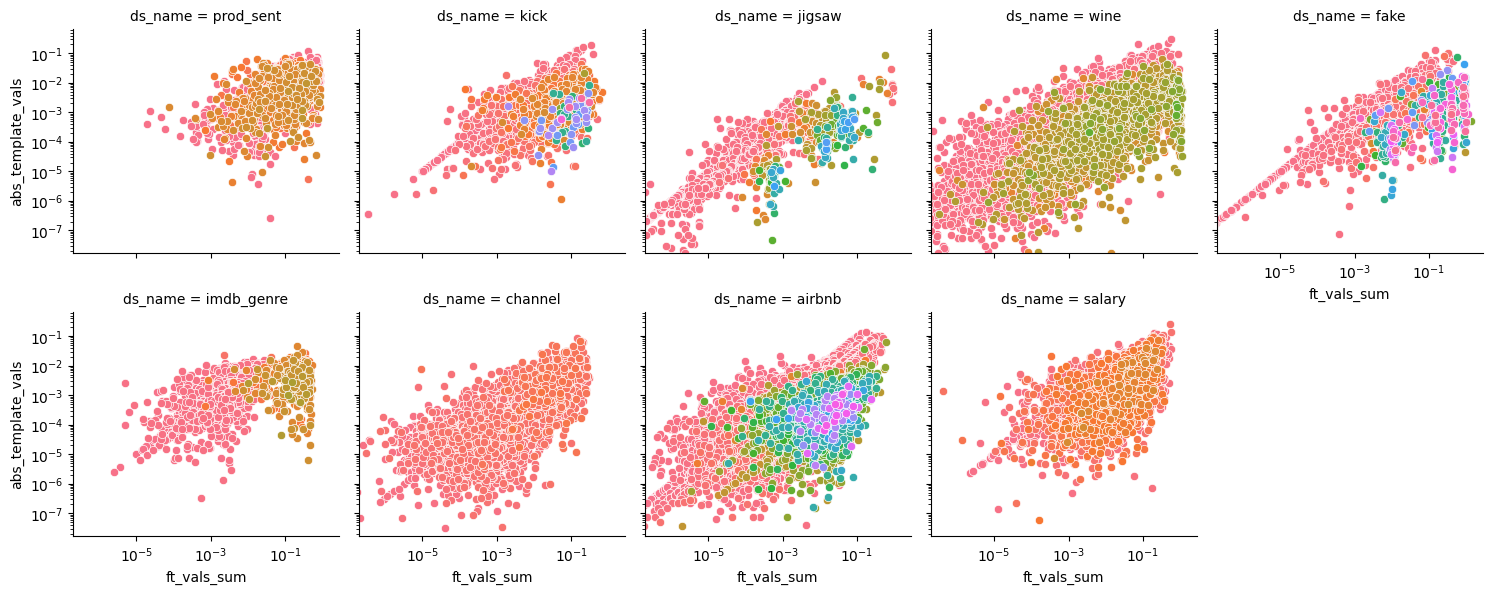

In [79]:
# sns.scatterplot(data=my_df, x="num_ft_tokens", y='abs_template_vals', hue='ds_name')#, alpha=0.01)
# Set plot size
# Create a FacetGrid with the desired variables
my_df["log_num_ft_tokens"] = np.log(my_df["num_ft_tokens"])
# cmap = sns.cubehelix_palette(rot=-.2, as_cmap=True)
g = sns.FacetGrid(data=my_df, col="ds_name",
                  hue="log_num_ft_tokens", col_wrap=5)

# # Define the scatterplot for each subplot
g.map(sns.scatterplot, "ft_vals_sum", "abs_template_vals")

# Adjust the layout of the subplots
g.tight_layout()
g.set(xscale="log")
g.set(yscale="log")
# g.add_legend()

plt.show()

Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
Using the boxplot function without specifying `hue_order` is likely to produce an incorrect plot.


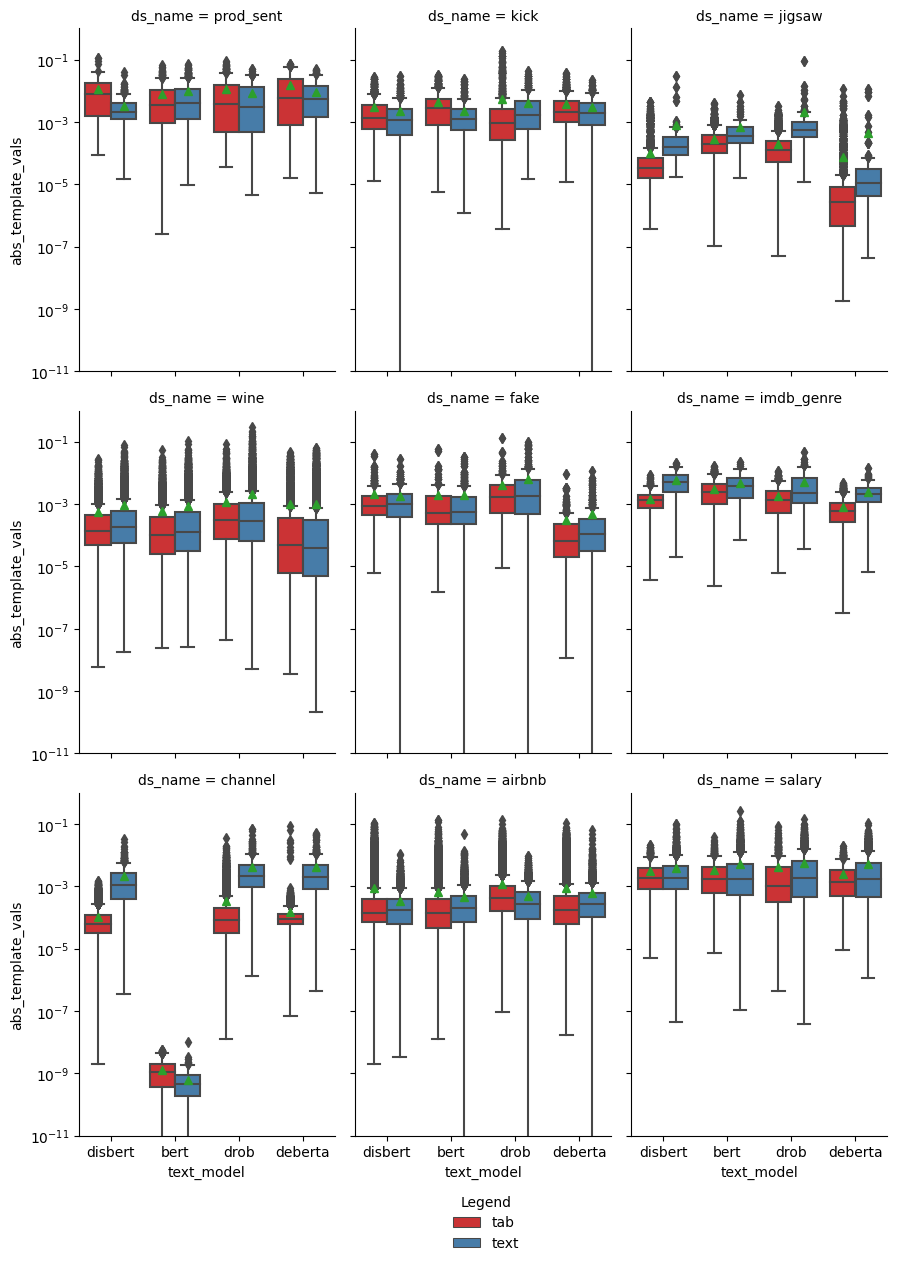

In [46]:
g = sns.FacetGrid(data=my_df, col="ds_name", col_wrap=3, height=4, aspect=0.75)

# # Define the scatterplot for each subplot
g.map(sns.boxplot, "text_model", "abs_template_vals",
      "tab_or_text", palette="Set1", showmeans=True)

# # Add mean points to each boxplot
# for ax in g.axes.flat:
#     # Calculate the mean for each category
#     means = my_df.groupby("text_model")["abs_template_vals"].mean()

#     # Plot mean points
#     for i, label in enumerate(means.index):
#         mean_val = means[label]
#         ax.scatter(i, mean_val, marker='x', color=f"C{i}", s=100, label=f"Mean {label}")

# Adjust the layout of the subplots
g.tight_layout()
# g.set(xscale="log")
g.set(yscale="log", ylim=(0.00000000001, 1))
g.add_legend(title="Legend", bbox_to_anchor=(0.5, 0.01), loc="upper center")

# plt.show()
# sns.boxplot(data=my_df, x="tab_or_text", y="abs_template_vals", hue="text_model")
# plt.yscale("log")

<Axes: xlabel='ft_vals_median', ylabel='abs_template_vals'>

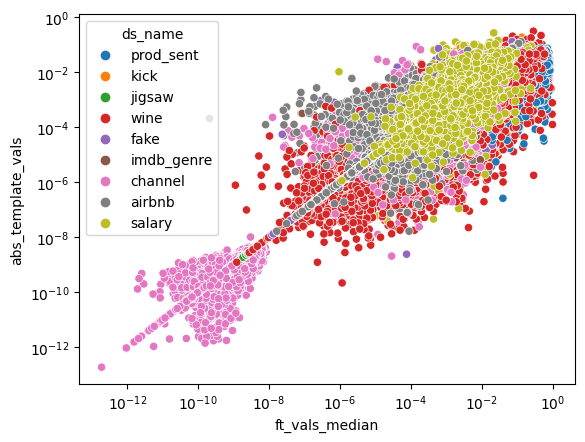

In [81]:
plt.xscale("log")
plt.yscale("log")
sns.scatterplot(data=my_df, x="ft_vals_median",
                y="abs_template_vals", hue="ds_name")

In [89]:
my_df

abs_template_vals  template_vals  abs_ft_vals_sum  ft_vals_sum  \
0                0.001363      -0.001363         0.003093     0.003093   
1                0.002132       0.002132         0.050701    -0.050701   
2                0.011435      -0.011435         0.514044     0.514044   
3                0.010666       0.010666         0.466435    -0.466435   
4                0.001969      -0.001969         0.071347    -0.071347   
...                   ...            ...              ...          ...   
319995           0.001474       0.001474         0.020481     0.020481   
319996           0.000891       0.000891         0.012805     0.012805   
319997           0.000184       0.000184         0.002142     0.002142   
319998           0.000718      -0.000718         0.006959    -0.006959   
319999           0.000599       0.000599         0.000880     0.000880   

        ft_vals_mean  ft_vals_median  ft_vals_max  ft_vals_min tab_or_text  \
0           0.003093        0.003093     0.003093     0.003093         tab   
1           0.050701        0.050701     0.050701     0.050701         tab   
2           0.514044        0.514044     0.514044     0.514044         tab   
3           0.466435        0.466435     0.466435     0.466435         tab   
4           0.002932        0.001549     0.015131     0.000097        text   
...              ...             ...          ...          ...         ...   
319995      0.004096        0.000517     0.015439     0.000517        text   
319996      0.002561        0.000914     0.008006     0.000914        text   
319997      0.000428        0.000207     0.001191     0.000207        text   
319998      0.001392        0.000092     0.005903     0.000092        text   
319999      0.000515        0.000283     0.001190     0.000283        text   

        label ft_num  example_num    ds_name text_model  num_ft_tokens  \
0           0      0            0  prod_sent    disbert              1   
1           1      0            0  prod_sent    disbert              1   
2           2      0            0  prod_sent    disbert              1   
3           3      0            0  prod_sent    disbert              1   
4           0      1            0  prod_sent    disbert             25   
...       ...    ...          ...        ...        ...            ...   
319995      1      5           99     salary    deberta              5   
319996      2      5           99     salary    deberta              5   
319997      3      5           99     salary    deberta              5   
319998      4      5           99     salary    deberta              5   
319999      5      5           99     salary    deberta              5   

        label_sum  log_num_ft_tokens  med_diff   row_sum  
0       -0.082323           0.000000 -0.001729  0.001729  
1       -0.173341           0.000000 -0.048569 -0.048569  
2        0.575669           0.000000 -0.502609  0.502609  
3       -0.320005           0.000000 -0.455769 -0.455769  
4       -0.082323           3.218876  0.000420 -0.073316  
...           ...                ...       ...       ...  
319995   0.073014           1.609438  0.000957  0.021955  
319996   0.086059           1.609438 -0.000023  0.013696  
319997   0.012754           1.609438 -0.000023  0.002326  
319998  -0.027191           1.609438  0.000625 -0.007677  
319999   0.084573           1.609438  0.000316  0.001479  

[320000 rows x 19 columns]

## Repeat with scaled df

In [113]:
scaled_df = my_df[abs(my_df["label_sum"]) > 0.1]

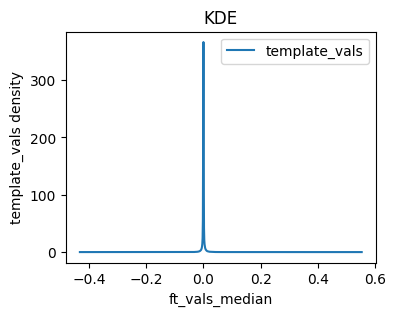

In [114]:
# Set up the figure and axes
fig, ax = plt.subplots(figsize=(4, 3))

# Plot the KDE on a logarithmic scale
scaled_df.plot.kde(x="ft_vals_median", y="template_vals", ax=ax)

# Set the y-axis scale to logarithmic
# ax.set_xscale('log')

# Add labels and title
ax.set_xlabel("ft_vals_median")
ax.set_ylabel("template_vals density")
ax.set_title("KDE")

# Display the plot
plt.show()

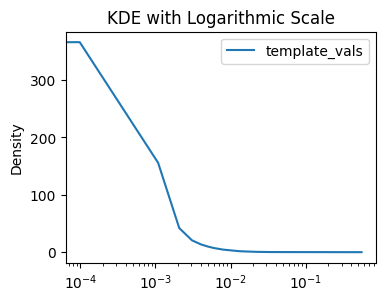

In [115]:
# Set up the figure and axes
fig, ax = plt.subplots(figsize=(4, 3))

y_col = "template_vals"
x_col = "ft_vals_median"
# Plot the KDE on a logarithmic scale
scaled_df.plot.kde(x=x_col, y=y_col, ax=ax)

# Set the y-axis scale to logarithmic
ax.set_xscale("log")

# Add labels and title
# ax.set_xlabel(x_col)
# ax.set_ylabel(f"{y_col} density")
ax.set_title("KDE with Logarithmic Scale")

# Display the plot
plt.show()

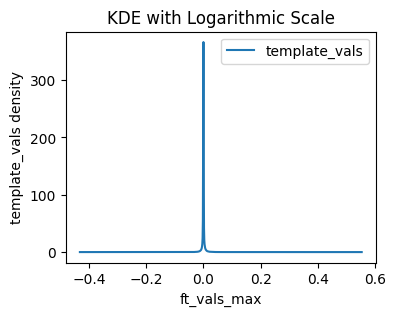

In [116]:
# Set up the figure and axes
fig, ax = plt.subplots(figsize=(4, 3))

y_col = "template_vals"
x_col = "ft_vals_max"
# Plot the KDE on a logarithmic scale
scaled_df.plot.kde(x=x_col, y=y_col, ax=ax)

# Set the y-axis scale to logarithmic
# ax.set_xscale("log")

# Add labels and title
ax.set_xlabel(x_col)
ax.set_ylabel(f"{y_col} density")
ax.set_title("KDE with Logarithmic Scale")

# Display the plot
plt.show()

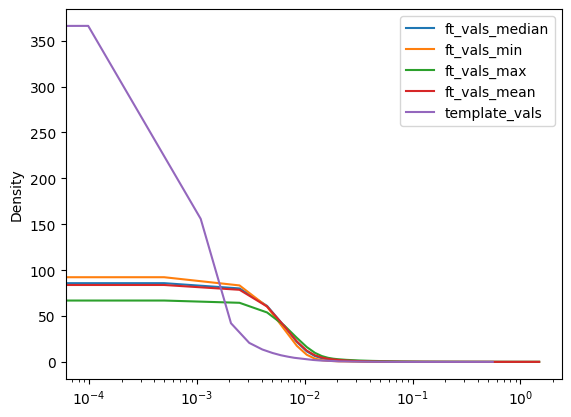

In [117]:
cols = [
    "ft_vals_median",
    "ft_vals_min",
    "ft_vals_max",
    "ft_vals_mean",
    "template_vals",
]
scaled_df[cols].plot.kde(
    # x=x_col,
    # y="template_vals",
    # ax=ax,
)
plt.xscale("log")
plt.show()

In [118]:
from scipy.stats import ks_2samp
import numpy as np

x_cols = ["ft_vals_median", "ft_vals_min", "ft_vals_max"]
y_col = "template_vals"

# Calculate the KS statistic for each x-axis column
for x_col in x_cols:
    ks_stat, p_value = ks_2samp(
        scaled_df[x_col], scaled_df[y_col], alternative="two-sided", mode="auto"
    )
    print(f"KS Statistic for {x_col}: {ks_stat}, p-value: {p_value}")
    # scipy.stats.ks_2samp(data1, data2, alternative='two-sided', mode='auto')

KS Statistic for ft_vals_median: 0.5047424126135858, p-value: 0.0
KS Statistic for ft_vals_min: 0.5047424126135858, p-value: 0.0
KS Statistic for ft_vals_max: 0.5047424126135858, p-value: 0.0


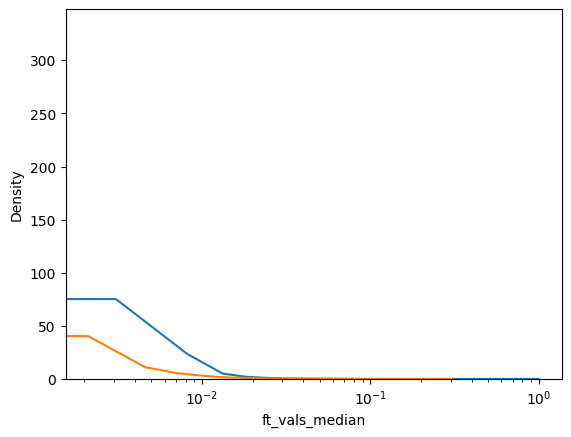

In [119]:
sns.kdeplot(data=(scaled_df), x="ft_vals_median")
sns.kdeplot(data=(scaled_df), x="template_vals")
plt.xscale("log")

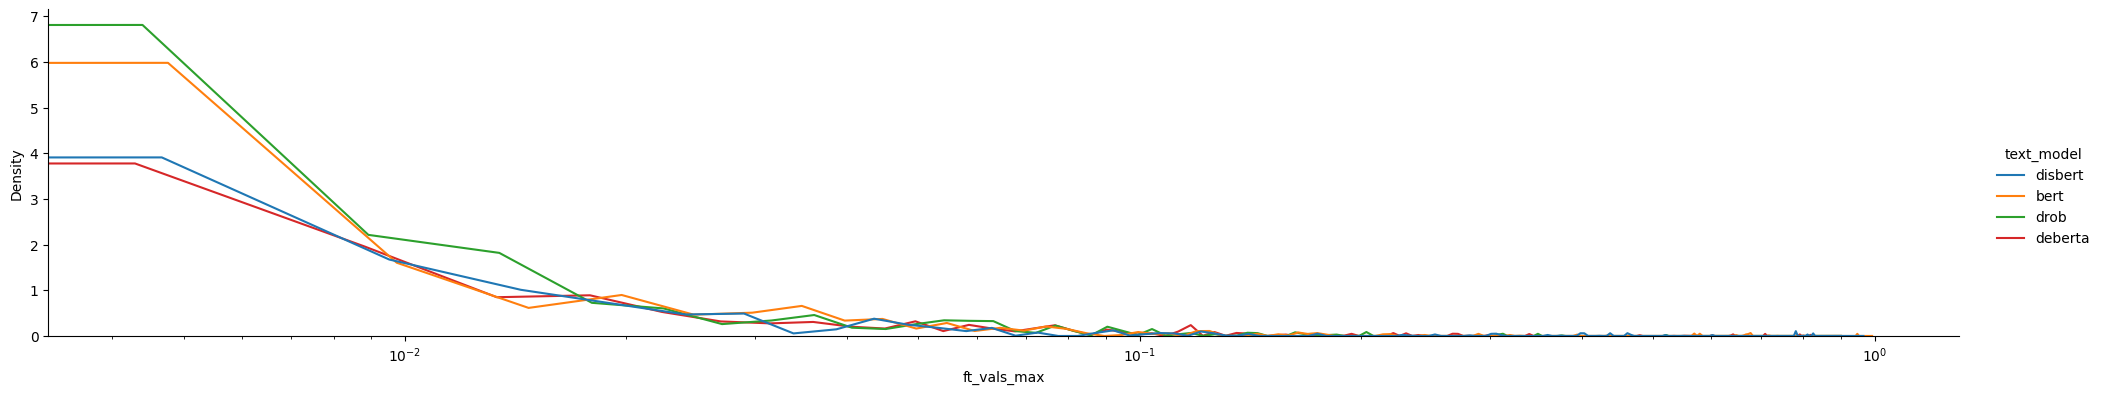

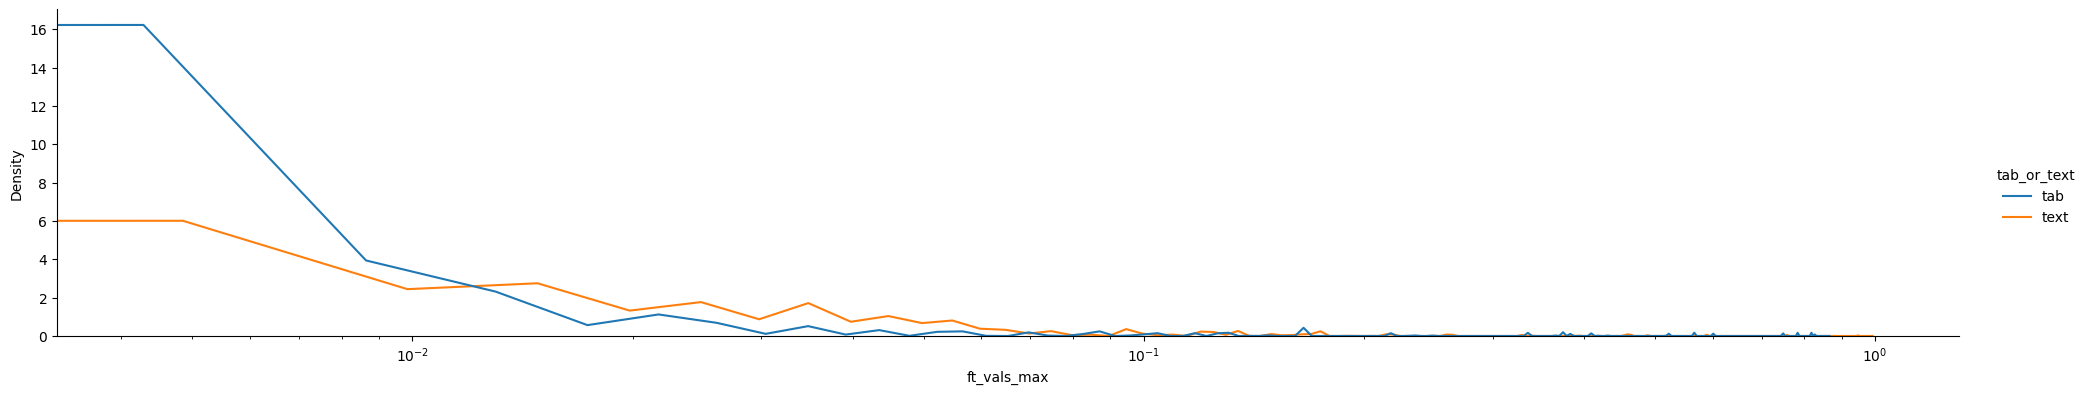

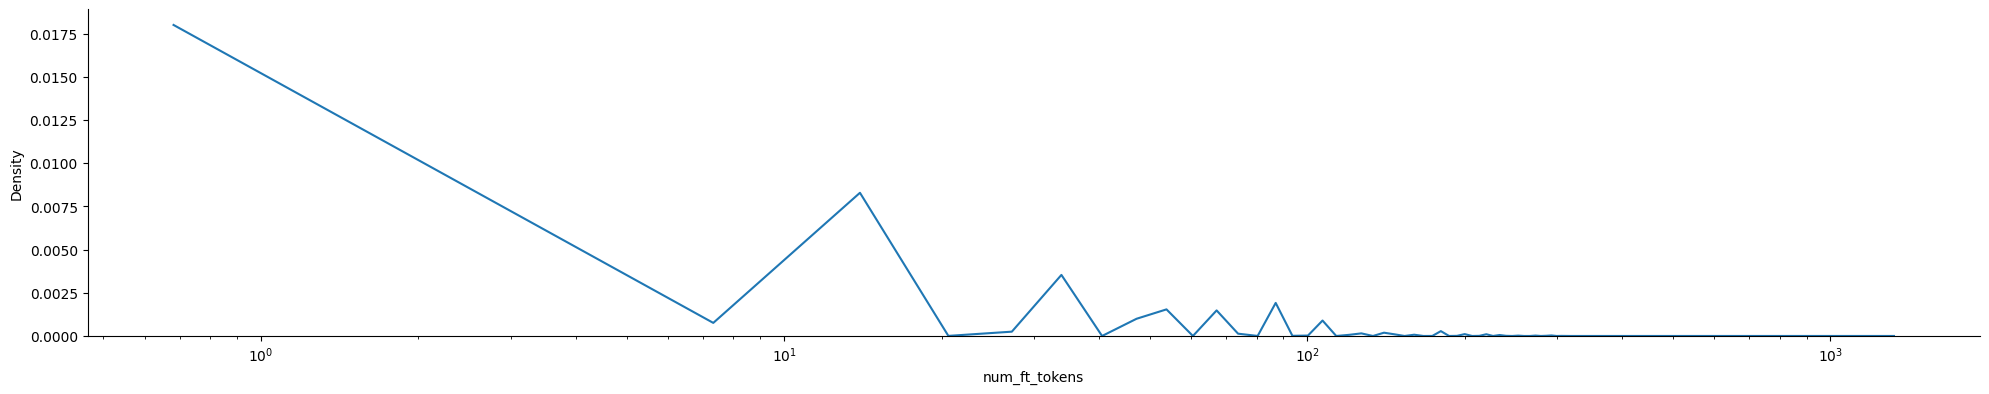

In [120]:
sns.displot(
    scaled_df, x=x_col, kind="kde", hue="text_model", bw_adjust=0.01, height=4, aspect=5
)
plt.xscale("log")
sns.displot(
    scaled_df,
    x=x_col,
    kind="kde",
    hue="tab_or_text",
    bw_adjust=0.005,
    height=4,
    aspect=5,
)
plt.xscale("log")
sns.displot(my_df, x="num_ft_tokens", kind="kde",
            bw_adjust=0.05, height=4, aspect=5)
plt.xscale("log")
# reduce plot area
# sns.displot(my_df, x='num_ft_tokens', kind='kde', bw_adjust=0.1,  height=4, aspect=2)

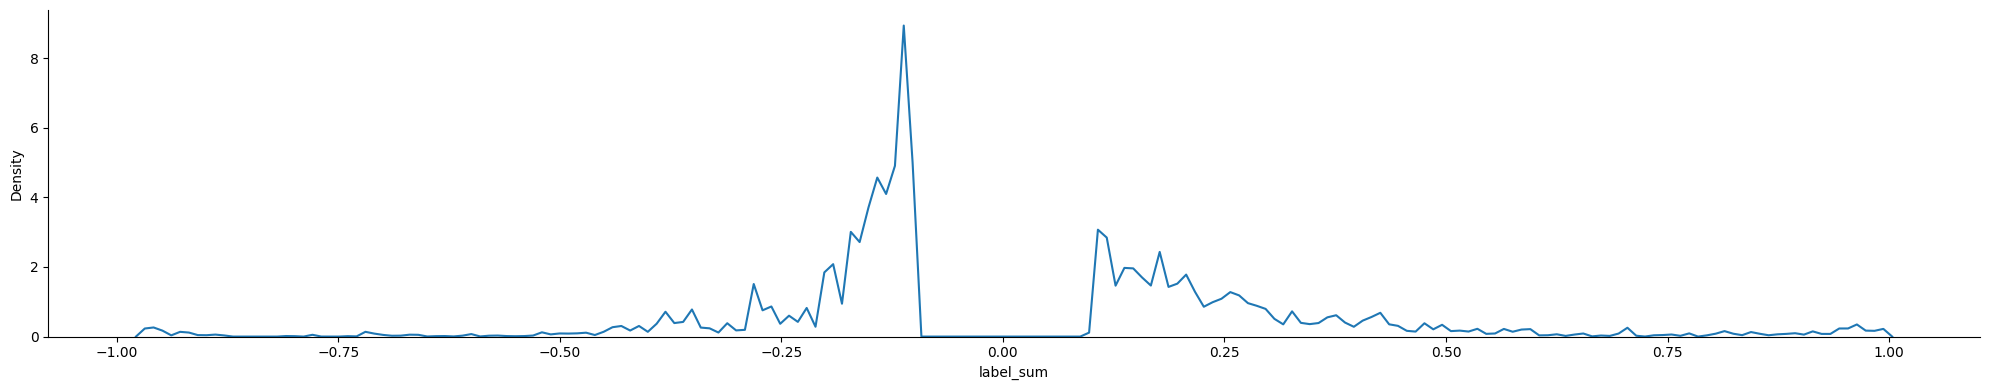

In [121]:
sns.displot(scaled_df, x="label_sum", kind="kde",
            bw_adjust=0.05, height=4, aspect=5)
# plt.xscale('log')

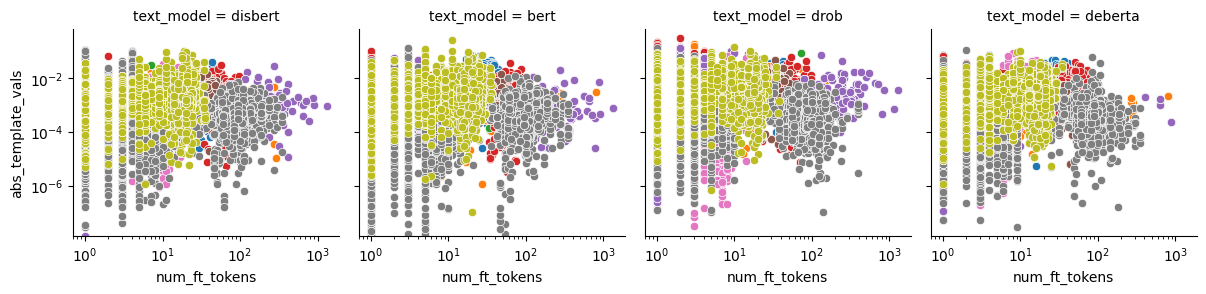

In [122]:
# sns.scatterplot(data=my_df, x="num_ft_tokens", y='abs_template_vals', hue='ds_name')#, alpha=0.01)
# Set plot size
# Create a FacetGrid with the desired variables
g = sns.FacetGrid(data=scaled_df, col="text_model", hue="ds_name", col_wrap=5)

# # Define the scatterplot for each subplot
g.map(sns.scatterplot, "num_ft_tokens", "abs_template_vals")

# Adjust the layout of the subplots
g.tight_layout()
plt.xscale("log")
plt.yscale("log")
# Display the plot
plt.show()

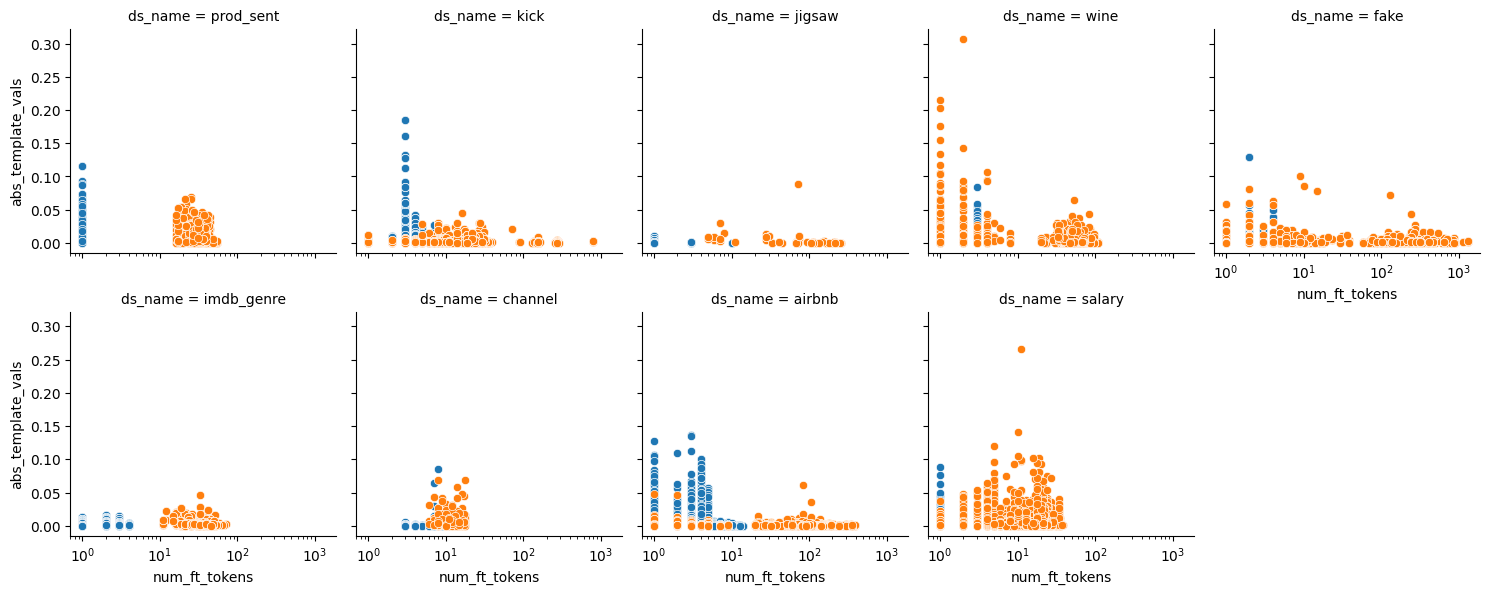

In [132]:
# sns.scatterplot(data=my_df, x="num_ft_tokens", y='abs_template_vals', hue='ds_name')#, alpha=0.01)
# Set plot size
# Create a FacetGrid with the desired variables
g = sns.FacetGrid(data=scaled_df, col="ds_name", hue="tab_or_text", col_wrap=5)

# # Define the scatterplot for each subplot
g.map(sns.scatterplot, "num_ft_tokens", "abs_template_vals")

# Adjust the layout of the subplots
g.tight_layout()
plt.xscale("log")
# plt.yscale("log")
# Display the plot
plt.show()


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


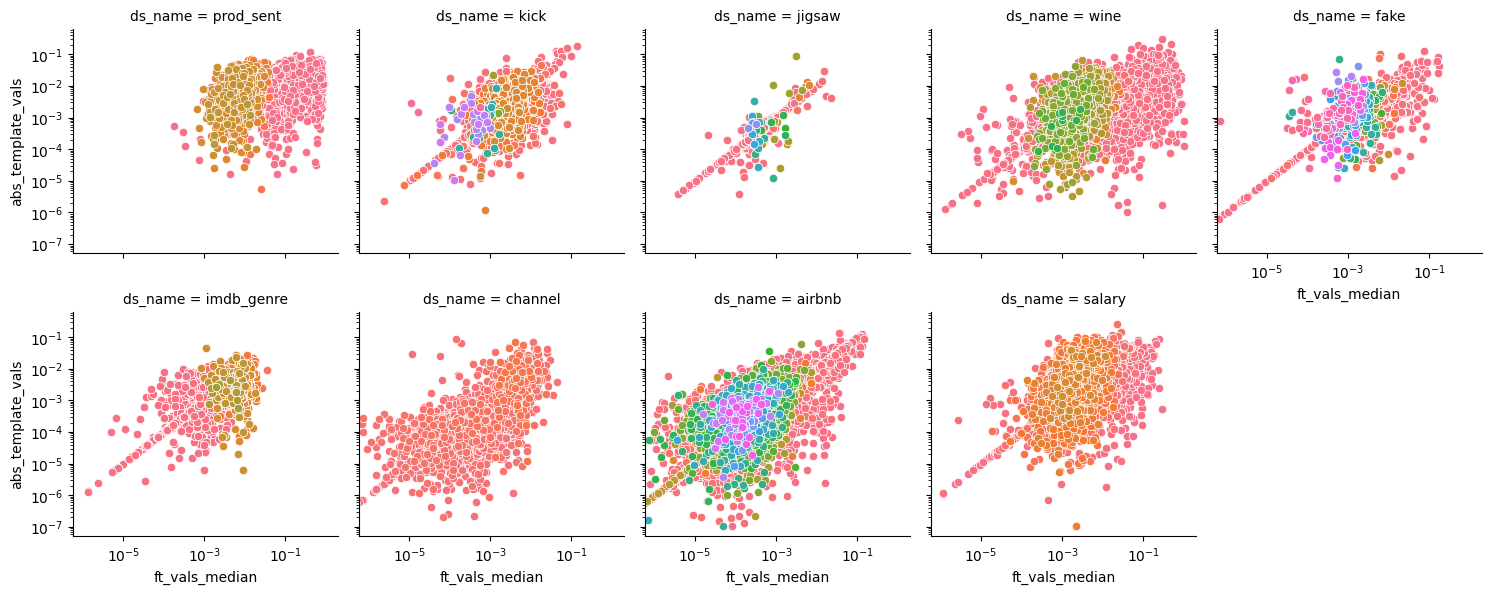

In [125]:
# sns.scatterplot(data=my_df, x="num_ft_tokens", y='abs_template_vals', hue='ds_name')#, alpha=0.01)
# Set plot size
# Create a FacetGrid with the desired variables
scaled_df["log_num_ft_tokens"] = np.log(scaled_df["num_ft_tokens"])
# cmap = sns.cubehelix_palette(rot=-.2, as_cmap=True)
g = sns.FacetGrid(data=scaled_df, col="ds_name",
                  hue="log_num_ft_tokens", col_wrap=5)

# # Define the scatterplot for each subplot
g.map(sns.scatterplot, "ft_vals_median", "abs_template_vals")

# Adjust the layout of the subplots
g.tight_layout()
g.set(xscale="log")
g.set(yscale="log")
# g.add_legend()

plt.show()

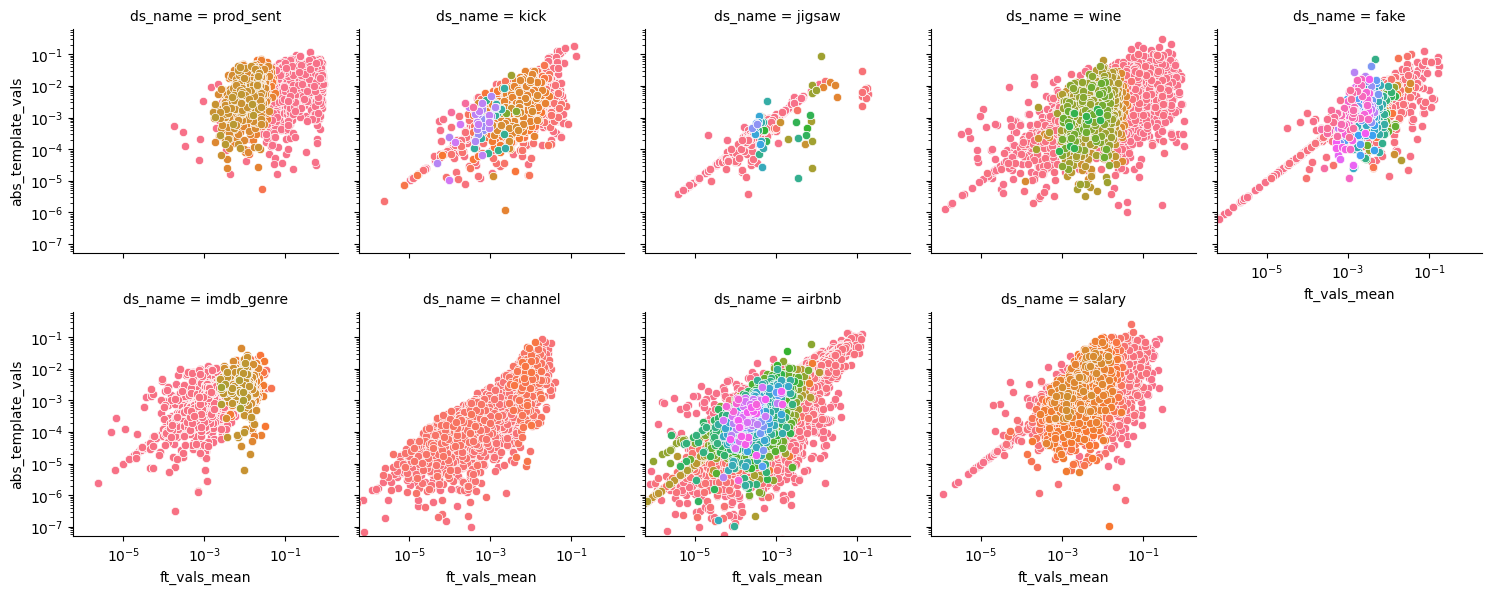

In [126]:
# sns.scatterplot(data=my_df, x="num_ft_tokens", y='abs_template_vals', hue='ds_name')#, alpha=0.01)
# Set plot size
# Create a FacetGrid with the desired variables
# cmap = sns.cubehelix_palette(rot=-.2, as_cmap=True)
g = sns.FacetGrid(data=scaled_df, col="ds_name",
                  hue="log_num_ft_tokens", col_wrap=5)

# # Define the scatterplot for each subplot
g.map(sns.scatterplot, "ft_vals_mean", "abs_template_vals")

# Adjust the layout of the subplots
g.tight_layout()
g.set(xscale="log")
g.set(yscale="log")
# g.add_legend()

plt.show()

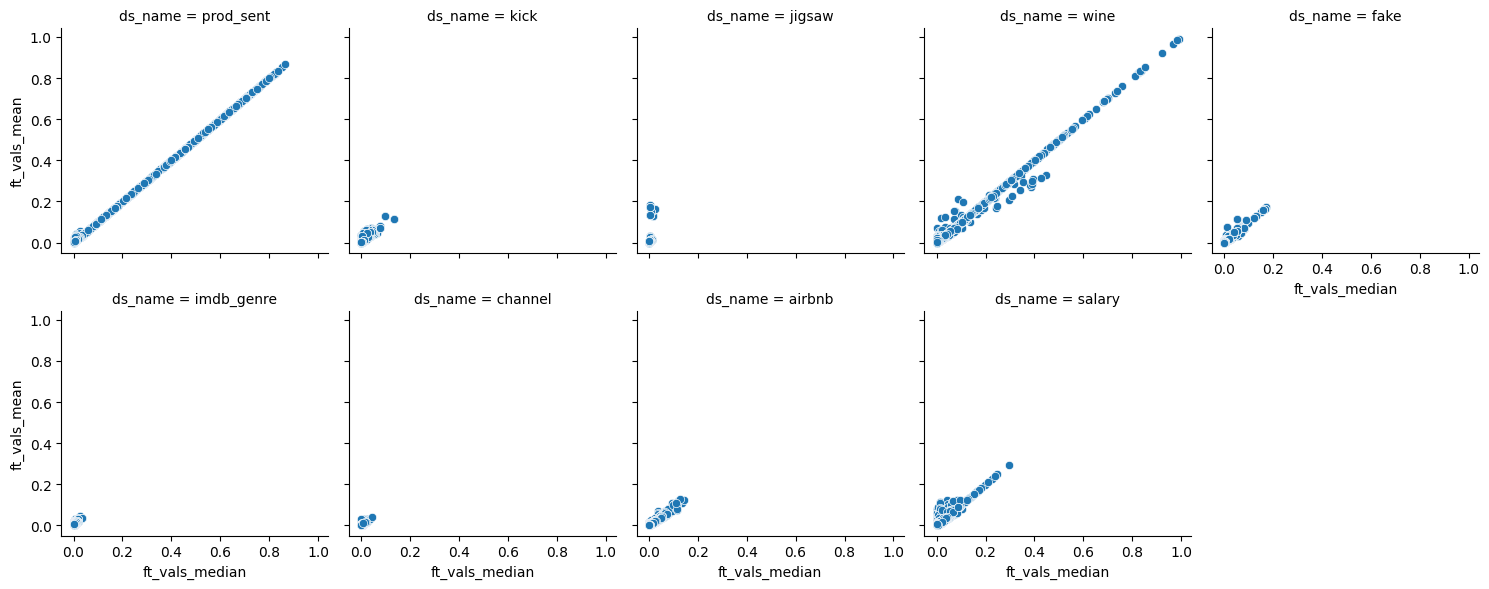

In [127]:
# sns.scatterplot(data=my_df, x="num_ft_tokens", y='abs_template_vals', hue='ds_name')#, alpha=0.01)
# Set plot size
# Create a FacetGrid with the desired variables
# cmap = sns.cubehelix_palette(rot=-.2, as_cmap=True)
g = sns.FacetGrid(data=scaled_df, col="ds_name", col_wrap=5)

# # Define the scatterplot for each subplot
g.map(sns.scatterplot, "ft_vals_median", "ft_vals_mean")

# Adjust the layout of the subplots
g.tight_layout()
# g.set(xscale="log")
# g.set(yscale="log")
# g.add_legend()

plt.show()


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


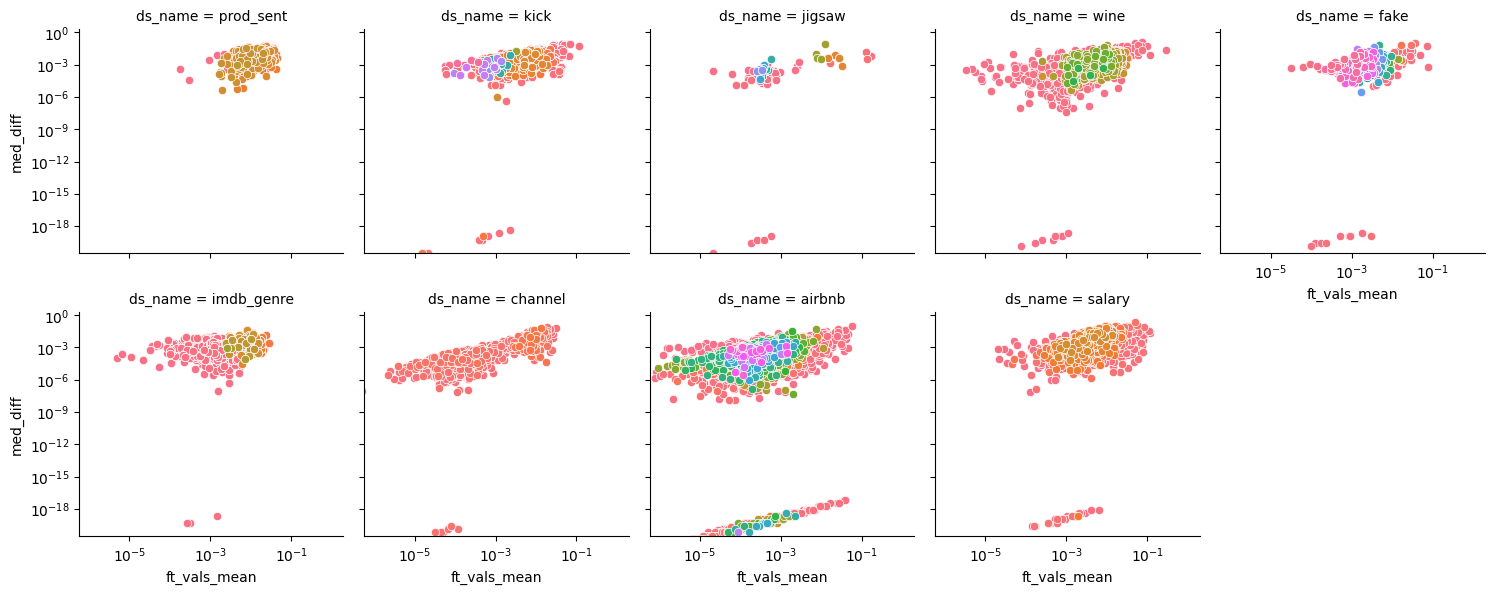

In [128]:
# sns.scatterplot(data=my_df, x="num_ft_tokens", y='abs_template_vals', hue='ds_name')#, alpha=0.01)
# Set plot size
# Create a FacetGrid with the desired variables
scaled_df["med_diff"] = scaled_df["abs_template_vals"] - \
    scaled_df["ft_vals_median"]
# cmap = sns.cubehelix_palette(rot=-.2, as_cmap=True)
g = sns.FacetGrid(data=scaled_df, col="ds_name",
                  hue="log_num_ft_tokens", col_wrap=5)

# # Define the scatterplot for each subplot
g.map(sns.scatterplot, "ft_vals_mean", "med_diff")

# Adjust the layout of the subplots
g.tight_layout()
g.set(xscale="log")
g.set(yscale="log")
# g.add_legend()

plt.show()

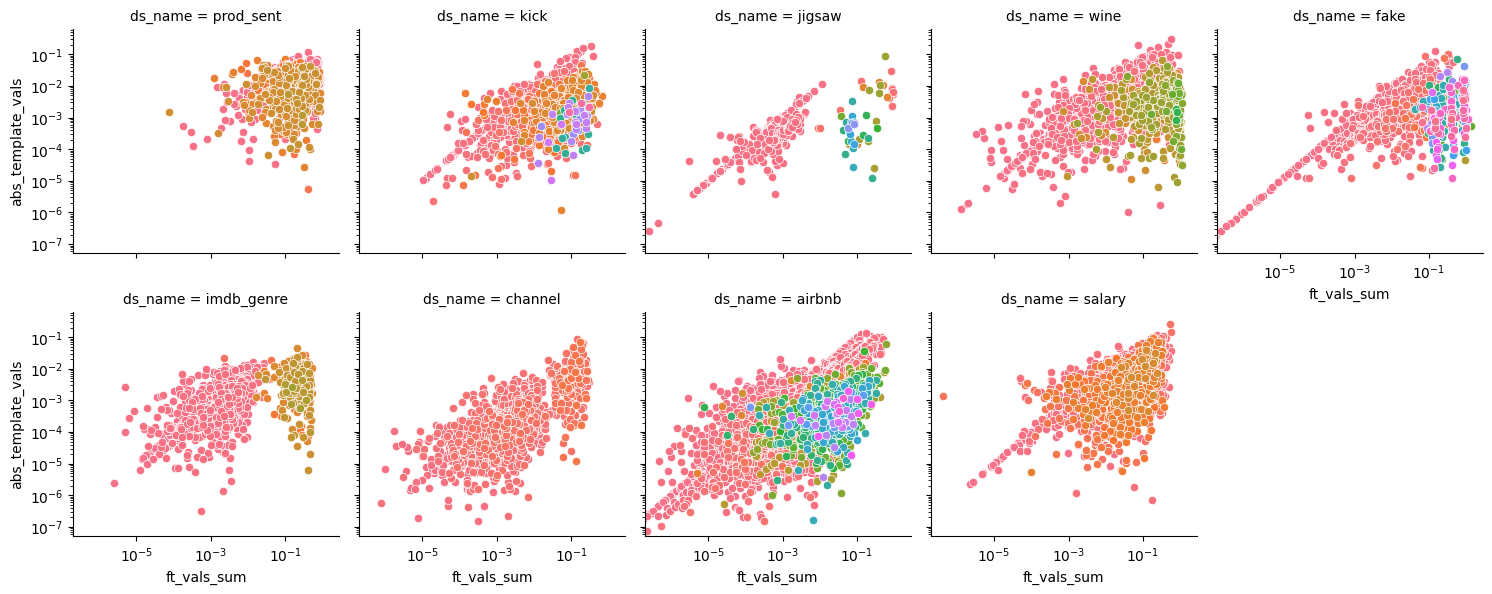

In [129]:
# sns.scatterplot(data=my_df, x="num_ft_tokens", y='abs_template_vals', hue='ds_name')#, alpha=0.01)
# Set plot size
# Create a FacetGrid with the desired variables
# cmap = sns.cubehelix_palette(rot=-.2, as_cmap=True)
g = sns.FacetGrid(data=scaled_df, col="ds_name",
                  hue="log_num_ft_tokens", col_wrap=5)

# # Define the scatterplot for each subplot
g.map(sns.scatterplot, "ft_vals_sum", "abs_template_vals")

# Adjust the layout of the subplots
g.tight_layout()
g.set(xscale="log")
g.set(yscale="log")
# g.add_legend()

plt.show()

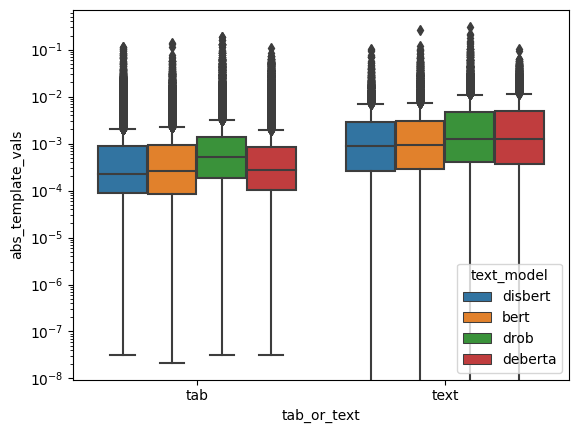

In [130]:
sns.boxplot(data=scaled_df, x="tab_or_text",
            y="abs_template_vals", hue="text_model")
plt.yscale("log")

<Axes: xlabel='ft_vals_median', ylabel='abs_template_vals'>

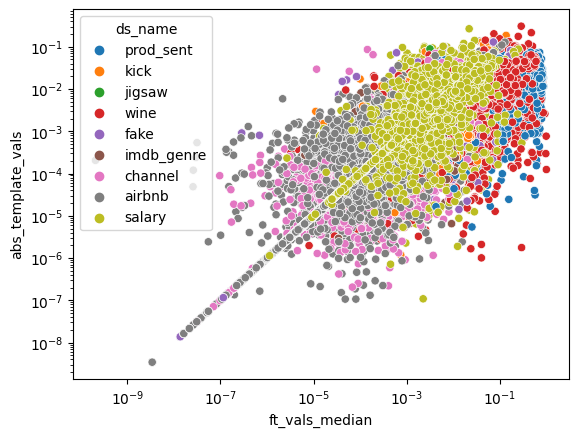

In [131]:
plt.xscale("log")
plt.yscale("log")
sns.scatterplot(
    data=scaled_df, x="ft_vals_median", y="abs_template_vals", hue="ds_name"
)

In [ ]:
my_df["row_sum"] = my_df["ft_vals_sum"] + my_df["template_vals"]

In [159]:
item_df

temp_median  temp_mean  temp_max  temp_min  ft_median   ft_mean  \
0         0.001666   0.001666  0.001969  0.001363   0.001651  0.002938   
1         0.002226   0.002226  0.002319  0.002132   0.002197  0.007560   
2         0.013723   0.013723  0.016012  0.011435   0.009354  0.033575   
3         0.011195   0.011195  0.011724  0.010666   0.008633  0.031005   
4         0.001293   0.001293  0.001839  0.000746   0.000649  0.002607   
...            ...        ...       ...       ...        ...       ...   
25595     0.003677   0.005280  0.014785  0.001474   0.003151  0.004932   
25596     0.001727   0.003465  0.012465  0.000486   0.002853  0.004156   
25597     0.000343   0.000563  0.001779  0.000184   0.000434  0.000620   
25598     0.002322   0.004197  0.013801  0.000718   0.002047  0.003372   
25599     0.001675   0.005670  0.025310  0.000590   0.001052  0.002497   

         ft_max    ft_min    ds_name text_model  num_ft_tokens  label_sum  \
0      0.015131  0.000097  prod_sent    disbert              5  -0.082323   
1      0.050701  0.000051  prod_sent    disbert             25  -0.173341   
2      0.514044  0.000028  prod_sent    disbert             25   0.575669   
3      0.466435  0.000082  prod_sent    disbert             25  -0.320005   
4      0.012396  0.000025  prod_sent    disbert             25  -0.075543   
...         ...       ...        ...        ...            ...        ...   
25595  0.026268  0.000517     salary    deberta              5   0.073014   
25596  0.021278  0.000486     salary    deberta              5   0.086059   
25597  0.002904  0.000183     salary    deberta              5   0.012754   
25598  0.021733  0.000092     salary    deberta              5  -0.027191   
25599  0.043114  0.000176     salary    deberta              5   0.084573   

       total_length  
0                37  
1                37  
2                37  
3                37  
4                37  
...             ...  
25595            61  
25596            61  
25597            61  
25598            61  
25599            61  

[25600 rows x 13 columns]

## We don't break down by feature here

<Axes: xlabel='ft_median', ylabel='temp_median'>

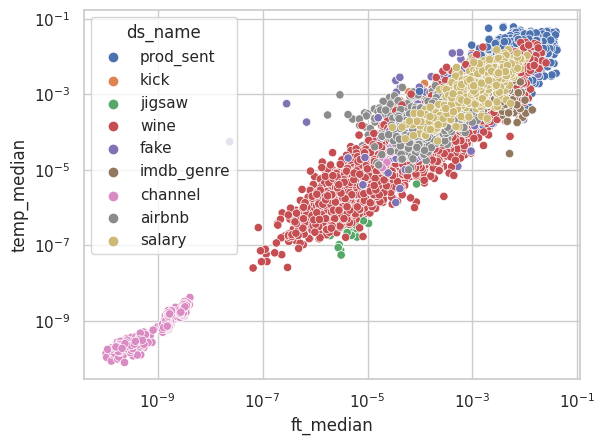

In [54]:
plt.xscale("log")
plt.yscale("log")
sns.scatterplot(data=item_df, x="ft_median", y="temp_median", hue="ds_name")

<Axes: xlabel='ft_median', ylabel='temp_median'>

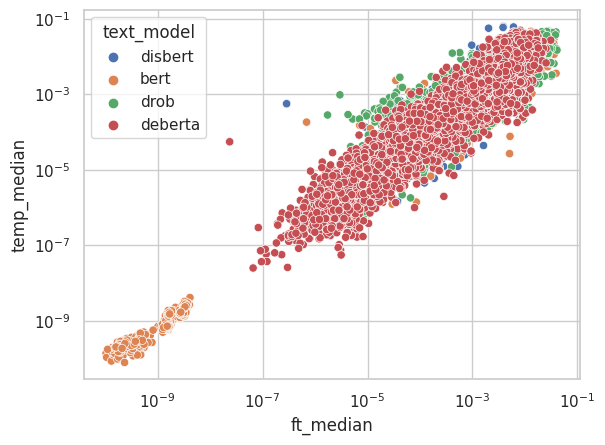

In [55]:
plt.xscale("log")
plt.yscale("log")
sns.scatterplot(data=item_df, x="ft_median", y="temp_median", hue="text_model")

In [12]:
y_log.values.reshape(-1, 1).min()

-23.27932206658636

In [9]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import numpy as np

# Assuming you have already imported the necessary libraries and have your data ready
# Log-transform the x and y variables
x_log = np.log(item_df["ft_median"])
y_log = np.log(item_df["temp_median"])

# Perform linear regression
reg = LinearRegression()
reg.fit(x_log.values.reshape(-1, 1), y_log.values.reshape(-1, 1))

# Calculate R-squared value
y_log_pred = reg.predict(x_log.values.reshape(-1, 1))
r2 = r2_score(y_log, y_log_pred)

# Plot the log-log scatter plot
plt.xscale("log")
plt.yscale("log")
sns.scatterplot(data=item_df, x="ft_median", y="temp_median", hue="ds_name")

# Add R-squared text to the plot
plt.text(0.1, 0.9, f"R-squared = {r2:.2f}", transform=plt.gca().transAxes)

# Show the plot
plt.show()

divide by zero encountered in log


ValueError: Input X contains infinity or a value too large for dtype('float64').

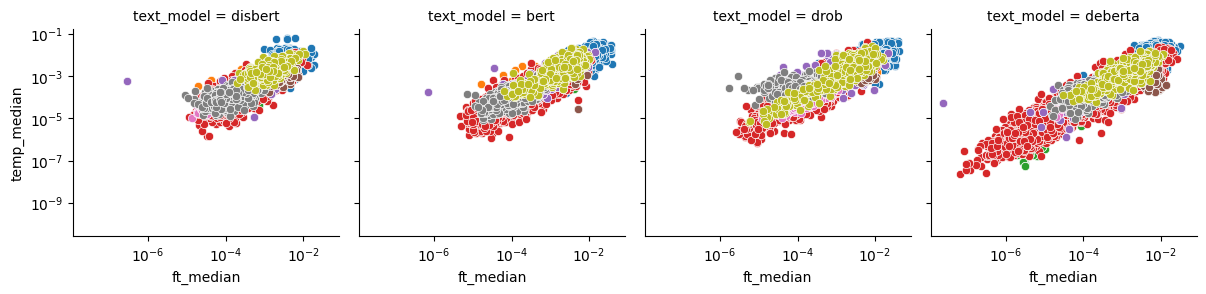

In [163]:
# sns.scatterplot(data=my_df, x="num_ft_tokens", y='abs_template_vals', hue='ds_name')#, alpha=0.01)
# Set plot size
# Create a FacetGrid with the desired variables
g = sns.FacetGrid(data=item_df, col="text_model", hue="ds_name", col_wrap=5)

# # Define the scatterplot for each subplot
g.map(sns.scatterplot, "ft_median", "temp_median")

# Adjust the layout of the subplots
g.tight_layout()
plt.xscale("log")
plt.yscale("log")
# Display the plot
plt.show()

<Axes: ylabel='Density'>

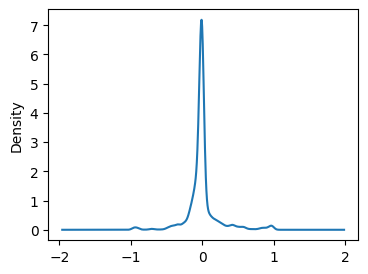

In [168]:
# This code plot a kde of label sum for each dataset
# Set up the figure and axes
fig, ax = plt.subplots(figsize=(4, 3))

# Plot the KDE on a logarithmic scale
item_df["label_sum"].plot.kde(x="label_sum", ax=ax)

# Set the y-axis scale to logarithmic
# ax.set_xscale('log')

In [170]:
item_df[abs(item_df["label_sum"]) > 0.05]["label_sum"]

0       -0.082323
1       -0.173341
2        0.575669
3       -0.320005
4       -0.075543
           ...   
25592    0.052945
25594   -0.229209
25595    0.073014
25596    0.086059
25599    0.084573
Name: label_sum, Length: 10528, dtype: float64